# Problem _A_PART_1 
 - Basic CNN and its varient
 - Image Data augmentation 

In [249]:
!nvidia-smi

Tue Apr 27 22:18:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000 wi... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8     1W /  N/A |   3019MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

* Developed this Notebook on Local system. GoogleCollable kept running out of memory

In [252]:
# import the necessary packages
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from IPython.display import display
from keras.utils import plot_model

In [76]:
#Read data from hdf5 file(code provided with assignment)
import numpy as np
import h5py

def loadDataH5():        
    
    with h5py.File('./earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))        
    return trainX, trainY, valX, valY

#### Get All details about data
    - Training & Validation
    - Image Dimesnion 
    - Classes

In [250]:

def get_working_data():
  trainX, trainY, valX, valY = loadDataH5()
  training_data_count,height,width,depth = trainX.shape
  unique_val, class_dist = np.unique(trainY,return_counts=True)
  print("Number of classes:",unique_val.shape[0])
  print("Class Value:",unique_val)
  print("Class distribution:",class_dist)
  print(trainX.shape,trainY.shape)
  print(valX.shape,valY.shape)
  trainX = trainX.astype("float") / 255.0
  valX = valX.astype("float") / 255.0
  return trainX, trainY, valX, valY,(height,width,depth,unique_val.shape[0])

g_trainX,g_trainY,g_valX,g_valY,(g_height,g_width,g_depth,g_classes) = \
                        get_working_data()

Number of classes: 9
Class Value: [0 1 2 3 4 5 6 7 8]
Class distribution: [2400 2400 2400 2000 2000 1600 2000 2400 2000]
(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


`As per number of instances for each class displayed above, the data set has class imbalance problem `

---

In [78]:
#Stores the performance matrix for each model run
class MODEL_PERFORMANCE:

  def __init__(self, val_loss,val_acc,train_loss,train_acc):
    self.val_loss = val_loss
    self.val_acc  = val_acc
    self.train_loss = train_loss
    self.train_acc = train_acc

class RECORD:

  def __init__(self):
    self.store = {}    

  def add_entry(self,name,performance):
    self.store[name] = performance

#Global object 
g_record_v1 = RECORD()
g_record_v2 = RECORD()
g_record_v3 = RECORD()

# PLOTS

In [253]:
def model_perfromance_summary_with_augmentation():
    model_perfromance_summary(g_record_v3)
    
def model_perfromance_summary(store_obj = g_record_v1):
    data = []
    for item in store_obj.store:
        perf = store_obj.store[item]   
        v_acc = max(perf.val_acc)
        print(item,":",v_acc)
        data.append([item,v_acc])

    df = pd.DataFrame(data, columns = ['Model', 'Val Acc'])
    display(df)
    plt.figure()
    plot = sns.barplot(y='Model', x='Val Acc', data=df)
    plt.show()

-  Sigle plot produced at the end of execution of each model depicting validation/training loss/accuracy 

In [162]:
# Performance plot for a model depicting training/validation loss/accuracy

def plot_model_performance(name,history,model_history):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
                    
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

  #Print best score 
  print("Model Performance Summary:")
  best_val_accuracy = max(history.history["val_accuracy"])
  print("Best Validation Accuracy: ",best_val_accuracy," at EPOCH:",\
        history.history["val_accuracy"].index(best_val_accuracy))
  min_val_loss = min(history.history["val_loss"])
  print("Min validation loss:",min_val_loss," at EPOCH:", \
        history.history["val_loss"].index(min_val_loss))
  
  #Store the above performance matrix
  model_history.add_entry(name,MODEL_PERFORMANCE( \
                             val_acc = history.history["val_accuracy"], \
                            val_loss = history.history["val_loss"], \
                            train_loss = history.history["loss"],
                            train_acc = history.history["accuracy"]))

In [163]:
from matplotlib.pyplot import draw, show

def compare_model_performance_with_lrs(model_name):
    
    compare_model_performance(model_name, model_name, model_name,\
                              model2_history = g_record_v2)
    
def compare_model_performance_with_augmentation(model_name):

    compare_model_performance(model_name, model_name, \
                              "Augmented " + model_name,\
                              model2_history = g_record_v3) 
    
    
def compare_model_performance_with_another(model1_name,model2_name):
    compare_model_performance(model1_name, model2_name, \
                      " 1: " + model1_name+" 2:"+model2_name,\
                              model2_history = g_record_v1)    

    

def compare_model_performance(model1_name,model2_name,title_suffix,\
                              model1_history = \
                              g_record_v1,model2_history = g_record_v1):
  
  mode1_per = model1_history.store[model1_name]
  mode2_per = model2_history.store[model2_name]

  model1_val_loss = mode1_per.val_loss
  model1_val_acc = mode1_per.val_acc
  model1_train_loss = mode1_per.train_loss
  model1_train_acc = mode1_per.train_acc
  
  model2_val_loss = mode2_per.val_loss
  model2_val_acc = mode2_per.val_acc
  model2_train_loss = mode2_per.train_loss
  model2_train_acc = mode2_per.train_acc

  plt.style.use("ggplot")
  
  fig, axes = plt.subplots(1,2,figsize=(12,5))
 
  epoch1_ran = len(model1_val_loss)
  epoch2_ran = len(model2_val_loss)

  plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
  axes[0].set_xlabel("EPOCH #")
  axes[0].set_ylabel("Loss")
  axes[0].set(title = title_suffix)
  axes[0].plot(np.arange(0,epoch1_ran),model1_val_loss,label="1: Val Loss")
  axes[0].plot(np.arange(0,epoch2_ran),model2_val_loss,label="2: Val Loss")
  axes[0].plot(np.arange(0,epoch1_ran),model1_train_loss,label="1: Train Loss")
  axes[0].plot(np.arange(0,epoch2_ran),model2_train_loss,label="2: Train Loss")
  axes[0].legend()
    
  axes[1].set_xlabel("EPOCH #")
  axes[1].set_ylabel("Accuracy")
  axes[1].set(title = title_suffix)
  axes[1].plot(np.arange(0,epoch1_ran),model1_val_acc,label="1: Val Acc")
  axes[1].plot(np.arange(0,epoch2_ran),model2_val_acc,label="2: Val Acc")
  axes[1].plot(np.arange(0,epoch1_ran),model1_train_acc,label="1: Train Acc")
  axes[1].plot(np.arange(0,epoch2_ran),model2_train_acc,label="2: Train Acc")
  axes[1].legend()
    
  fig.tight_layout()
  draw()
  plt.show()

#### Utility function for executing model
     - CNN Model with given dataset
     - CNN Model with augmented dataset

In [164]:
# This function used for building,compiling and testing the model
def call_model(model_name,callback_obj,input_data = (g_trainX,g_trainY, \
                                                     g_valX,g_valY),\
               inputshape = (g_height,g_width,g_depth), \
               classes = g_classes, iterations = 70,optimizer_obj=None, \
               model_history = g_record_v1):
    
  NUM_EPOCHS = iterations

  trainX,trainY,valX,valY = input_data
    
  model = model_name(inputshape,classes)
  tf.random.set_seed(207241)

  if optimizer_obj==None:
    optimizer_obj = keras.optimizers.SGD(learning_rate=0.01)

  model.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])
  print(model.summary())
  #Plot Model
  plots = plot_model(model,show_shapes=True,expand_nested=True)
  display(plots)
  
  history = model.fit(trainX, trainY, epochs = NUM_EPOCHS,  validation_data= \
                    (valX, valY), callbacks = callback_obj)  
  
  plot_model_performance(model.name,history,model_history)  
  #Invoking garbage collection manually helps allivaiting the problem of 
  # high RAM usage in
  gc.collect()

# **Callbacks**


1.   Early Stopping on Minimum Validation Loss
2.   Checkpointing on Minimum Validation Loss
3.   Learning Rate Schedular

In [165]:
#This function use generator object 
def call_model_with_augmentation(model_name,callback_obj,generator_obj,
               input_data = (g_trainX,g_trainY, g_valX,g_valY),\
               inputshape = (g_height,g_width,g_depth), \
               classes = g_classes, iterations = 70,optimizer_obj=None, \
               model_history = g_record_v3, batch_size = 32):
  NUM_EPOCHS = iterations
  trainX,trainY,valX,valY = input_data
  model = model_name(inputshape,classes)
  tf.random.set_seed(207241)
  if optimizer_obj==None:
    optimizer_obj = keras.optimizers.SGD(learning_rate = 0.01)
  model.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])
  print(model.summary())
  #Plot Model
  plots = plot_model(model,show_shapes=True,expand_nested=True)
  display(plots)
  
  history = model.fit(generator_obj, epochs = NUM_EPOCHS,  validation_data= \
                    (valX, valY), callbacks = callback_obj, \
                    steps_per_epoch=len(trainX)/ batch_size)  
  
  plot_model_performance(model.name,history,model_history)  
  gc.collect()

In [220]:
def get_early_stoping_cb_on_min_val_loss(patience_num = 2):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=2, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_min_val_loss(file_name):
  return ModelCheckpoint(file_name, monitor="val_loss", 	mode="min", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <10:
    return lr 
  else:
    return lr*tf.math.exp(-.1)
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=1)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          get_model_checkpoint_cb_on_min_val_loss(file_name),
          get_model_learning_rate_cb()]

# CNN MODEL
 - BaseLine_CNN
 - Baseline_d512_CNN
 - CONV2_d512_CNN
 - CONV3_d512_CNN
 - CONV4_d512_CNN
 - CONV4_d512_drop_CNN
 - CONV4_sp_d512_drop_CNN

#### BaseLine_CNN

In [255]:
#Base Model
def BaseLine_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "BaseLine_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),        
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

#### Train & test the model

Model: "BaseLine_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 9)                 294921    
Total params: 295,817
Trainable params: 295,817
Non-trainable params: 0
_________________________________________________________________
None


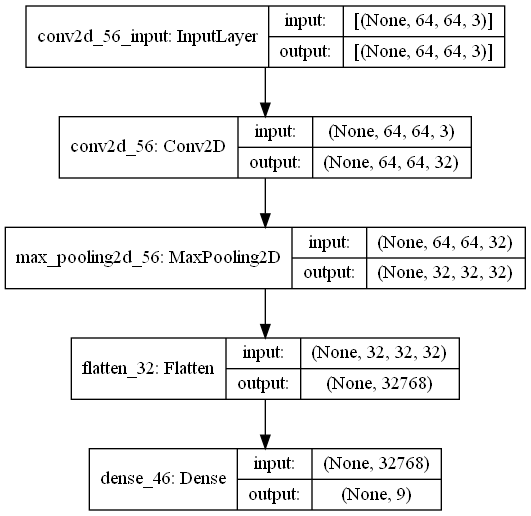

Epoch 1/70
600/600 [==============================] - 3s 5ms/step - loss: 1.8432 - accuracy: 0.3104 - val_loss: 1.4679 - val_accuracy: 0.4319
Epoch 2/70
600/600 [==============================] - 3s 5ms/step - loss: 1.4263 - accuracy: 0.4711 - val_loss: 1.3457 - val_accuracy: 0.4869
Epoch 3/70
600/600 [==============================] - 3s 5ms/step - loss: 1.2766 - accuracy: 0.5361 - val_loss: 1.1678 - val_accuracy: 0.5665
Epoch 4/70
600/600 [==============================] - 3s 5ms/step - loss: 1.1265 - accuracy: 0.5904 - val_loss: 1.0520 - val_accuracy: 0.6527
Epoch 5/70
600/600 [==============================] - 3s 5ms/step - loss: 1.0745 - accuracy: 0.6156 - val_loss: 1.0586 - val_accuracy: 0.6196
Epoch 6/70
600/600 [==============================] - 3s 5ms/step - loss: 1.0105 - accuracy: 0.6353 - val_loss: 0.9681 - val_accuracy: 0.6587
Epoch 7/70
600/600 [==============================] - 3s 5ms/step - loss: 0.9510 - accuracy: 0.6575 - val_loss: 1.0284 - val_accuracy: 0.6119
Epoch 

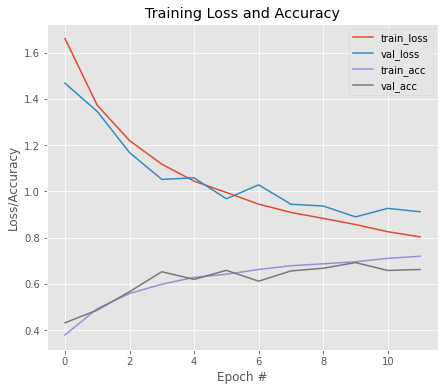

Model Performance Summary:
Best Validation Accuracy:  0.6922916769981384  at EPOCH: 9
Min validation loss: 0.8898637890815735  at EPOCH: 9


In [172]:
call_model(BaseLine_CNN,get_basic_callback())

In [173]:
def Baseline_d512_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "Baseline_d512_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

Model: "Baseline_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dense_48 (Dense)             (None, 9)                 4617      
Total params: 16,783,241
Trainable params: 16,783,241
Non-trainable params: 0
_________________________________________________________________
None


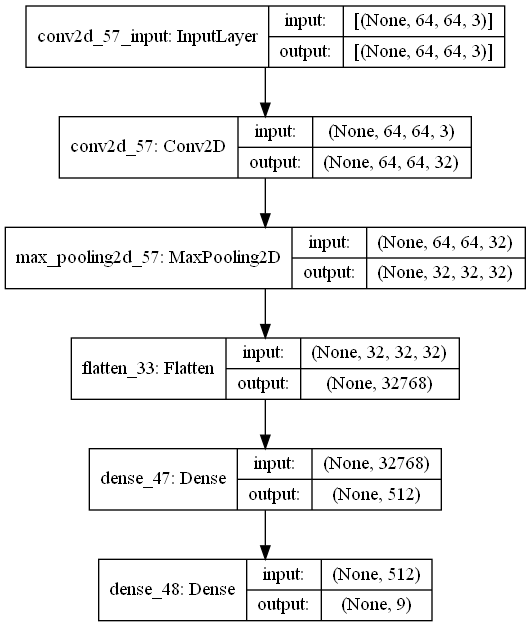

Epoch 1/70
600/600 [==============================] - 6s 9ms/step - loss: 1.8401 - accuracy: 0.3093 - val_loss: 1.5183 - val_accuracy: 0.4252
Epoch 2/70
600/600 [==============================] - 5s 8ms/step - loss: 1.4324 - accuracy: 0.4717 - val_loss: 1.3845 - val_accuracy: 0.4798
Epoch 3/70
600/600 [==============================] - 5s 9ms/step - loss: 1.3018 - accuracy: 0.5230 - val_loss: 1.1366 - val_accuracy: 0.5838
Epoch 4/70
600/600 [==============================] - 5s 9ms/step - loss: 1.1374 - accuracy: 0.5871 - val_loss: 1.0254 - val_accuracy: 0.6517
Epoch 5/70
600/600 [==============================] - 5s 9ms/step - loss: 1.0610 - accuracy: 0.6153 - val_loss: 1.0818 - val_accuracy: 0.6042
Epoch 6/70
600/600 [==============================] - 5s 9ms/step - loss: 0.9583 - accuracy: 0.6477 - val_loss: 0.8753 - val_accuracy: 0.6823
Epoch 7/70
600/600 [==============================] - 5s 9ms/step - loss: 0.8785 - accuracy: 0.6795 - val_loss: 0.9342 - val_accuracy: 0.6217
Epoch 

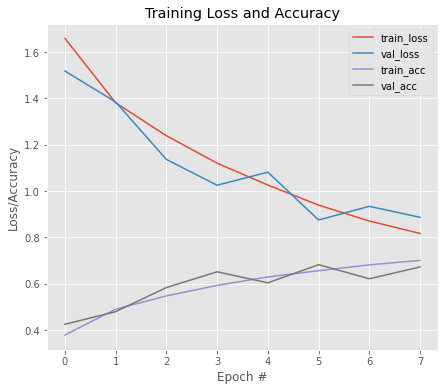

Model Performance Summary:
Best Validation Accuracy:  0.6822916865348816  at EPOCH: 5
Min validation loss: 0.8753153681755066  at EPOCH: 5


In [174]:
call_model(Baseline_d512_CNN,get_basic_callback())

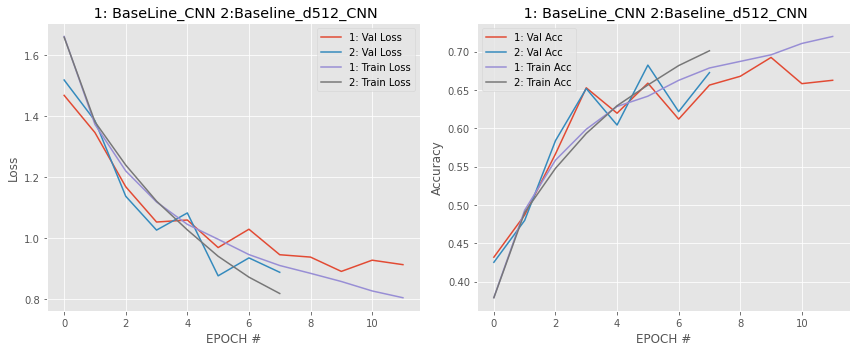

In [175]:
compare_model_performance_with_another("BaseLine_CNN","Baseline_d512_CNN")

In [176]:
def CONV2_d512_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV2_d512_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

Model: "CONV2_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dense_50 (Dense)             (None, 9)              

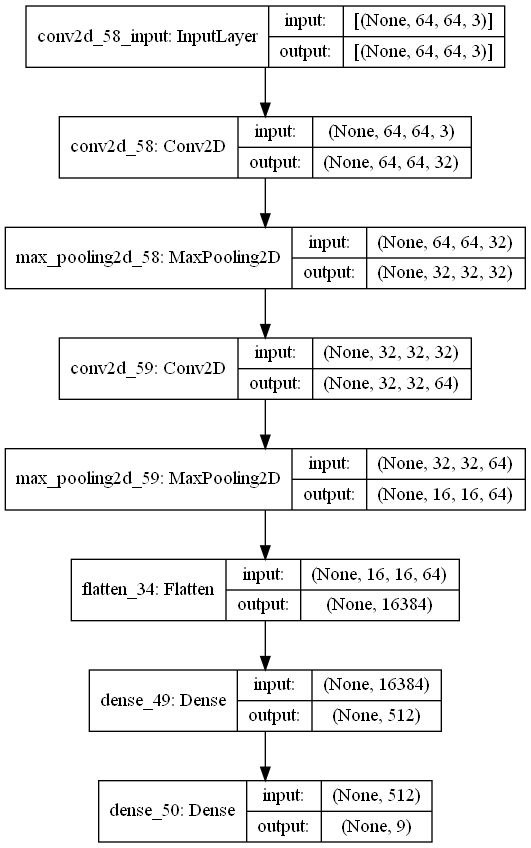

Epoch 1/70
600/600 [==============================] - 6s 9ms/step - loss: 1.9010 - accuracy: 0.2827 - val_loss: 1.5268 - val_accuracy: 0.3973
Epoch 2/70
600/600 [==============================] - 5s 9ms/step - loss: 1.4198 - accuracy: 0.4714 - val_loss: 1.4294 - val_accuracy: 0.4550
Epoch 3/70
600/600 [==============================] - 5s 9ms/step - loss: 1.2585 - accuracy: 0.5413 - val_loss: 1.0574 - val_accuracy: 0.6121
Epoch 4/70
600/600 [==============================] - 5s 9ms/step - loss: 1.0703 - accuracy: 0.6090 - val_loss: 0.9476 - val_accuracy: 0.6667
Epoch 5/70
600/600 [==============================] - 5s 9ms/step - loss: 0.9808 - accuracy: 0.6379 - val_loss: 1.0096 - val_accuracy: 0.6142
Epoch 6/70
600/600 [==============================] - 5s 9ms/step - loss: 0.8742 - accuracy: 0.6757 - val_loss: 0.7823 - val_accuracy: 0.7083
Epoch 7/70
600/600 [==============================] - 5s 9ms/step - loss: 0.8027 - accuracy: 0.7004 - val_loss: 0.8603 - val_accuracy: 0.6590
Epoch 

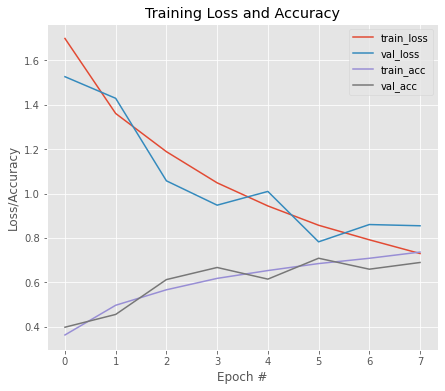

Model Performance Summary:
Best Validation Accuracy:  0.7083333134651184  at EPOCH: 5
Min validation loss: 0.7823141813278198  at EPOCH: 5


In [177]:
call_model(CONV2_d512_CNN,get_basic_callback())

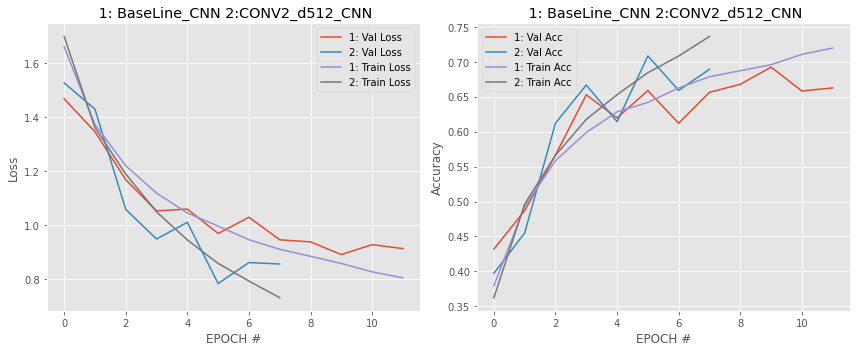

In [178]:
compare_model_performance_with_another("BaseLine_CNN","CONV2_d512_CNN")

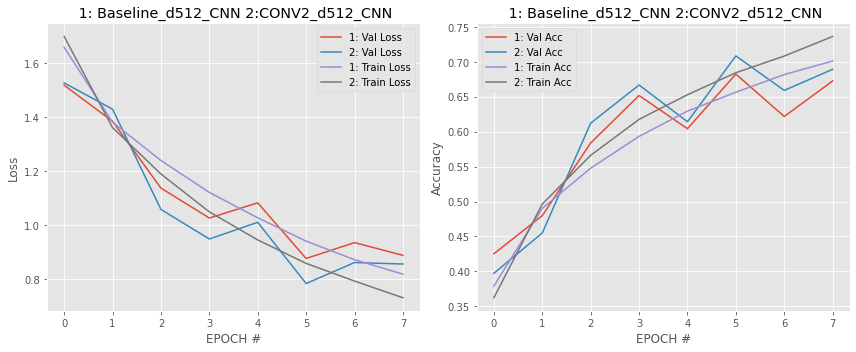

In [179]:
compare_model_performance_with_another("Baseline_d512_CNN","CONV2_d512_CNN")

In [180]:
def CONV3_d512_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV3_d512_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

Model: "CONV3_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 8192)           

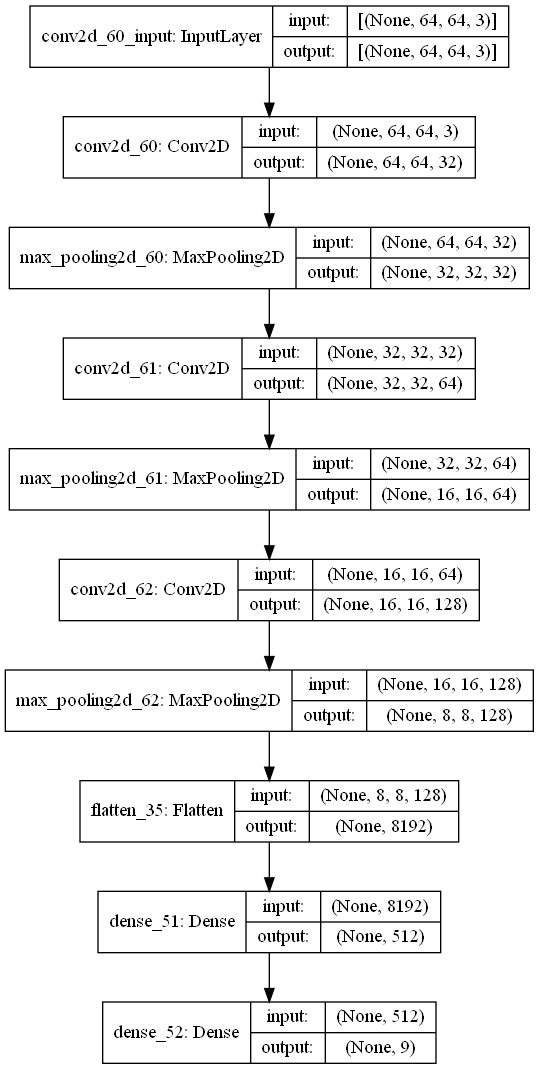

Epoch 1/70
600/600 [==============================] - 6s 10ms/step - loss: 1.9823 - accuracy: 0.2614 - val_loss: 1.4851 - val_accuracy: 0.4400
Epoch 2/70
600/600 [==============================] - 6s 9ms/step - loss: 1.4408 - accuracy: 0.4697 - val_loss: 1.4267 - val_accuracy: 0.4556
Epoch 3/70
600/600 [==============================] - 6s 9ms/step - loss: 1.2735 - accuracy: 0.5332 - val_loss: 1.1006 - val_accuracy: 0.5800
Epoch 4/70
600/600 [==============================] - 6s 9ms/step - loss: 1.0972 - accuracy: 0.5995 - val_loss: 0.9847 - val_accuracy: 0.6508
Epoch 5/70
600/600 [==============================] - 6s 9ms/step - loss: 1.0023 - accuracy: 0.6309 - val_loss: 1.2914 - val_accuracy: 0.5281
Epoch 6/70
600/600 [==============================] - 5s 9ms/step - loss: 0.8859 - accuracy: 0.6774 - val_loss: 0.7810 - val_accuracy: 0.7121
Epoch 7/70
600/600 [==============================] - 6s 9ms/step - loss: 0.8144 - accuracy: 0.7007 - val_loss: 0.8350 - val_accuracy: 0.6790
Epoch

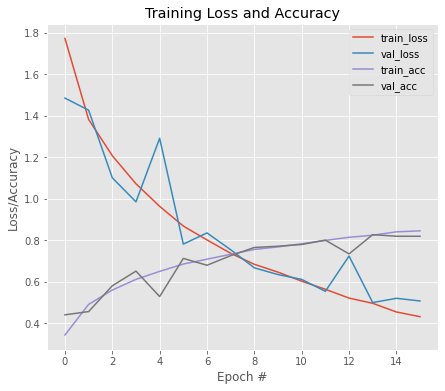

Model Performance Summary:
Best Validation Accuracy:  0.8266666531562805  at EPOCH: 13
Min validation loss: 0.49907103180885315  at EPOCH: 13


In [181]:
call_model(CONV3_d512_CNN,get_basic_callback())

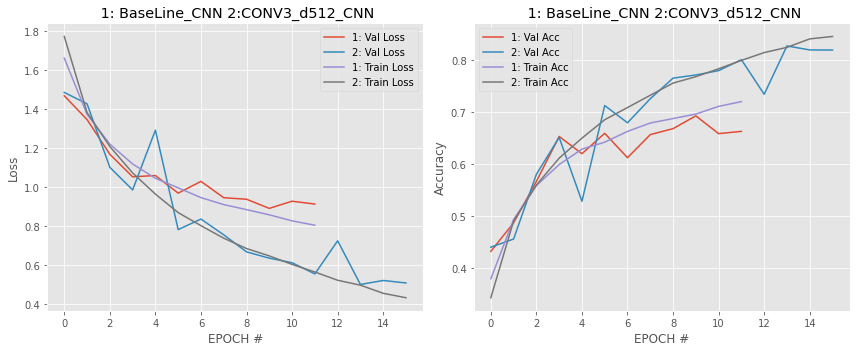

In [182]:
compare_model_performance_with_another("BaseLine_CNN","CONV3_d512_CNN")

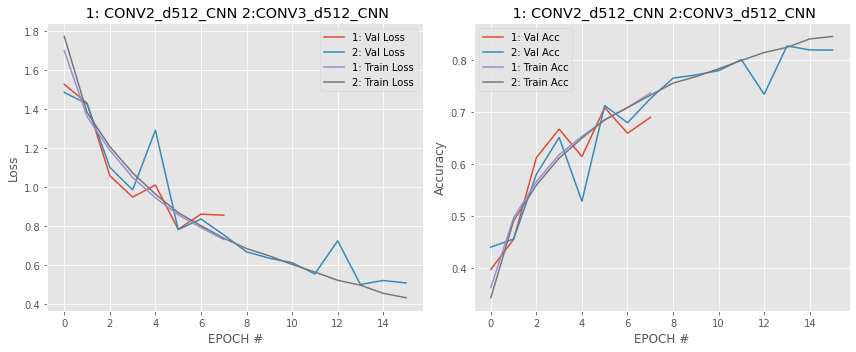

In [183]:
compare_model_performance_with_another("CONV2_d512_CNN","CONV3_d512_CNN")

In [184]:
def CONV4_d512_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV4_d512_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

Model: "CONV4_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 8, 8, 256)      

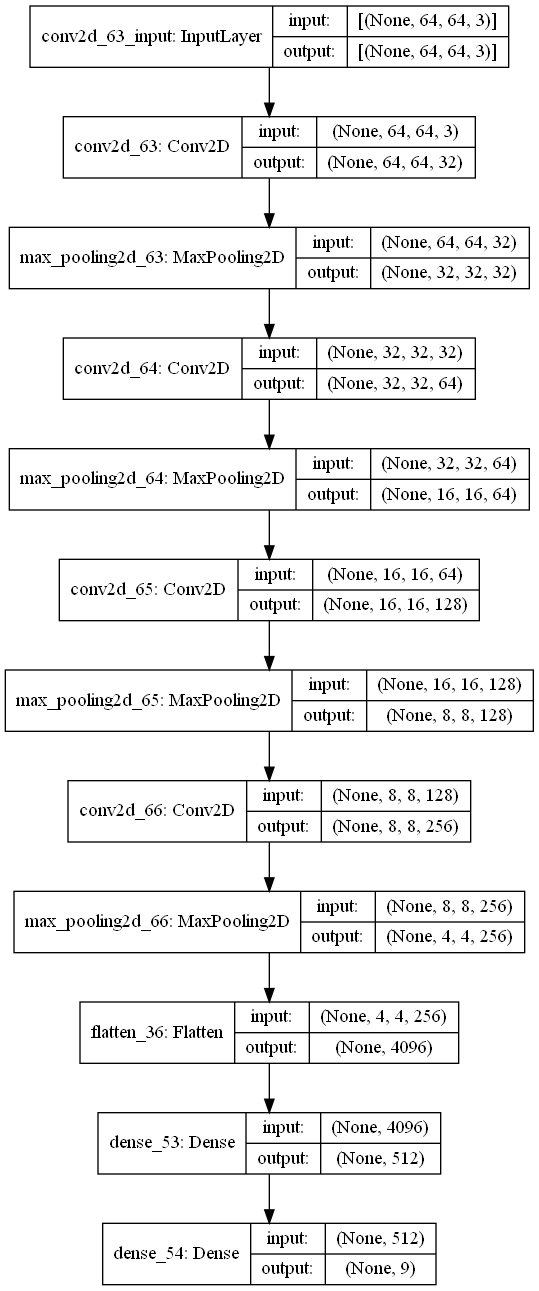

Epoch 1/70
600/600 [==============================] - 7s 11ms/step - loss: 2.0482 - accuracy: 0.2105 - val_loss: 1.6069 - val_accuracy: 0.3517
Epoch 2/70
600/600 [==============================] - 6s 10ms/step - loss: 1.5320 - accuracy: 0.4238 - val_loss: 1.5614 - val_accuracy: 0.4040
Epoch 3/70
600/600 [==============================] - 6s 10ms/step - loss: 1.3290 - accuracy: 0.5126 - val_loss: 1.1441 - val_accuracy: 0.5700
Epoch 4/70
600/600 [==============================] - 6s 10ms/step - loss: 1.1531 - accuracy: 0.5789 - val_loss: 1.0980 - val_accuracy: 0.6046
Epoch 5/70
600/600 [==============================] - 6s 10ms/step - loss: 1.0534 - accuracy: 0.6062 - val_loss: 1.2358 - val_accuracy: 0.5523
Epoch 6/70
600/600 [==============================] - 6s 10ms/step - loss: 0.9305 - accuracy: 0.6575 - val_loss: 0.8351 - val_accuracy: 0.6852
Epoch 7/70
600/600 [==============================] - 6s 10ms/step - loss: 0.8596 - accuracy: 0.6761 - val_loss: 0.9135 - val_accuracy: 0.6406

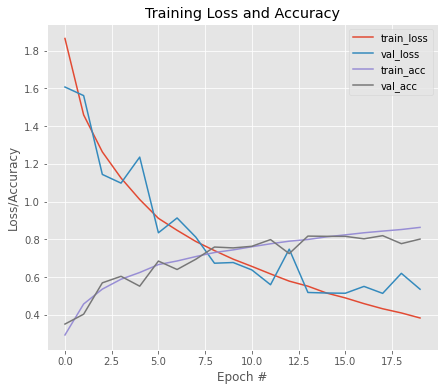

Model Performance Summary:
Best Validation Accuracy:  0.8197916746139526  at EPOCH: 17
Min validation loss: 0.5141973495483398  at EPOCH: 17


In [185]:
call_model(CONV4_d512_CNN,get_basic_callback())

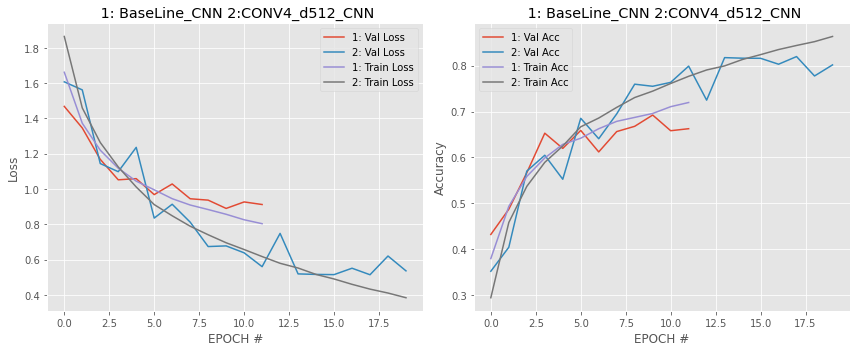

In [187]:
compare_model_performance_with_another("BaseLine_CNN","CONV4_d512_CNN")

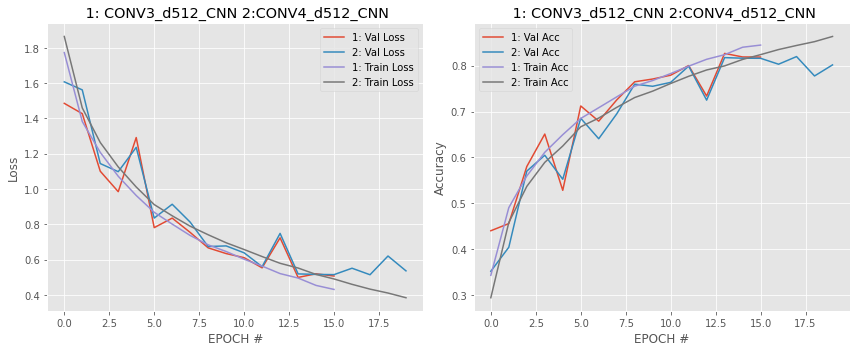

In [188]:
compare_model_performance_with_another("CONV3_d512_CNN","CONV4_d512_CNN")

In [189]:
def CONV4_d512_drop_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV4_d512_drop_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

Model: "CONV4_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 8, 8, 256) 

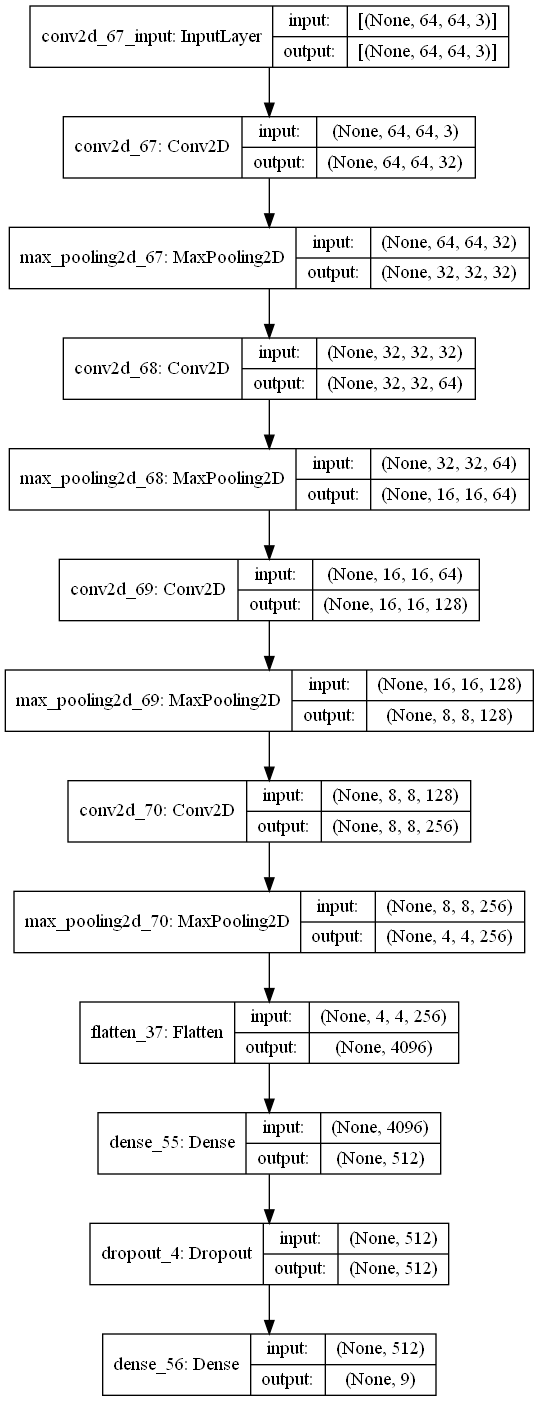

Epoch 1/70
600/600 [==============================] - 7s 11ms/step - loss: 2.0522 - accuracy: 0.2078 - val_loss: 1.5972 - val_accuracy: 0.3562
Epoch 2/70
600/600 [==============================] - 6s 10ms/step - loss: 1.5470 - accuracy: 0.4198 - val_loss: 1.6167 - val_accuracy: 0.3894
Epoch 3/70
600/600 [==============================] - 6s 10ms/step - loss: 1.3495 - accuracy: 0.5018 - val_loss: 1.1400 - val_accuracy: 0.5681
Epoch 4/70
600/600 [==============================] - 6s 10ms/step - loss: 1.1734 - accuracy: 0.5722 - val_loss: 1.0588 - val_accuracy: 0.6165
Epoch 5/70
600/600 [==============================] - 6s 10ms/step - loss: 1.0765 - accuracy: 0.6030 - val_loss: 1.3523 - val_accuracy: 0.5198
Epoch 6/70
600/600 [==============================] - 6s 10ms/step - loss: 0.9630 - accuracy: 0.6479 - val_loss: 0.8524 - val_accuracy: 0.6792
Epoch 7/70
600/600 [==============================] - 6s 10ms/step - loss: 0.8899 - accuracy: 0.6708 - val_loss: 0.9523 - val_accuracy: 0.6279

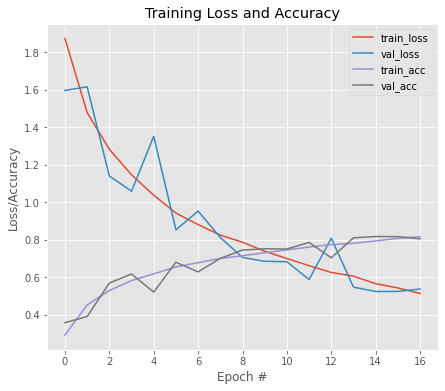

Model Performance Summary:
Best Validation Accuracy:  0.8166666626930237  at EPOCH: 14
Min validation loss: 0.52278733253479  at EPOCH: 14


In [190]:
call_model(CONV4_d512_drop_CNN,get_basic_callback())

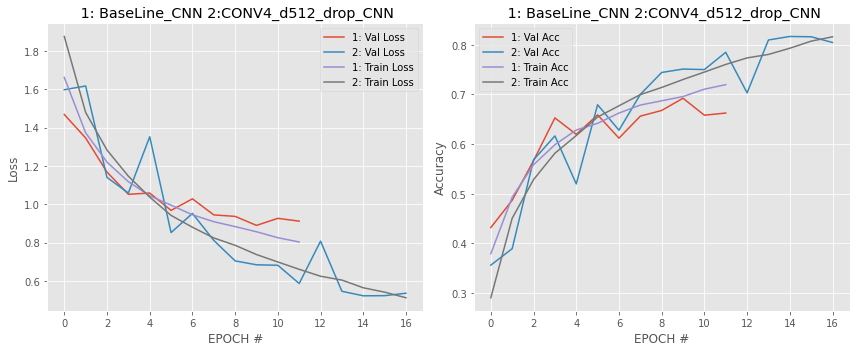

In [191]:
compare_model_performance_with_another("BaseLine_CNN","CONV4_d512_drop_CNN")

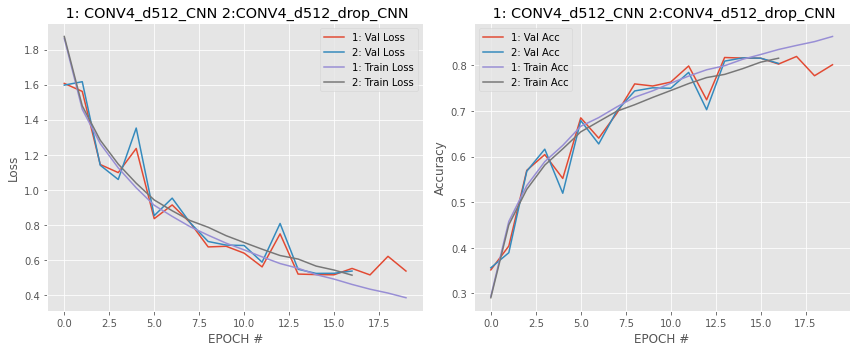

In [192]:
compare_model_performance_with_another("CONV4_d512_CNN","CONV4_d512_drop_CNN")

In [193]:
def CONV4_sp_d512_drop_CNN(inputshape, classes):
    
  model = \
  keras.Sequential( name = "CONV4_sp_d512_drop_CNN", layers= \
      [
        tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                    input_shape=inputshape, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.SpatialDropout2D(0.2),
        keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.SpatialDropout2D(0.2),
        keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.SpatialDropout2D(0.2),
        keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.SpatialDropout2D(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(classes, activation='softmax')
      ])
  
  return model

Model: "CONV4_sp_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_9 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 16, 16, 

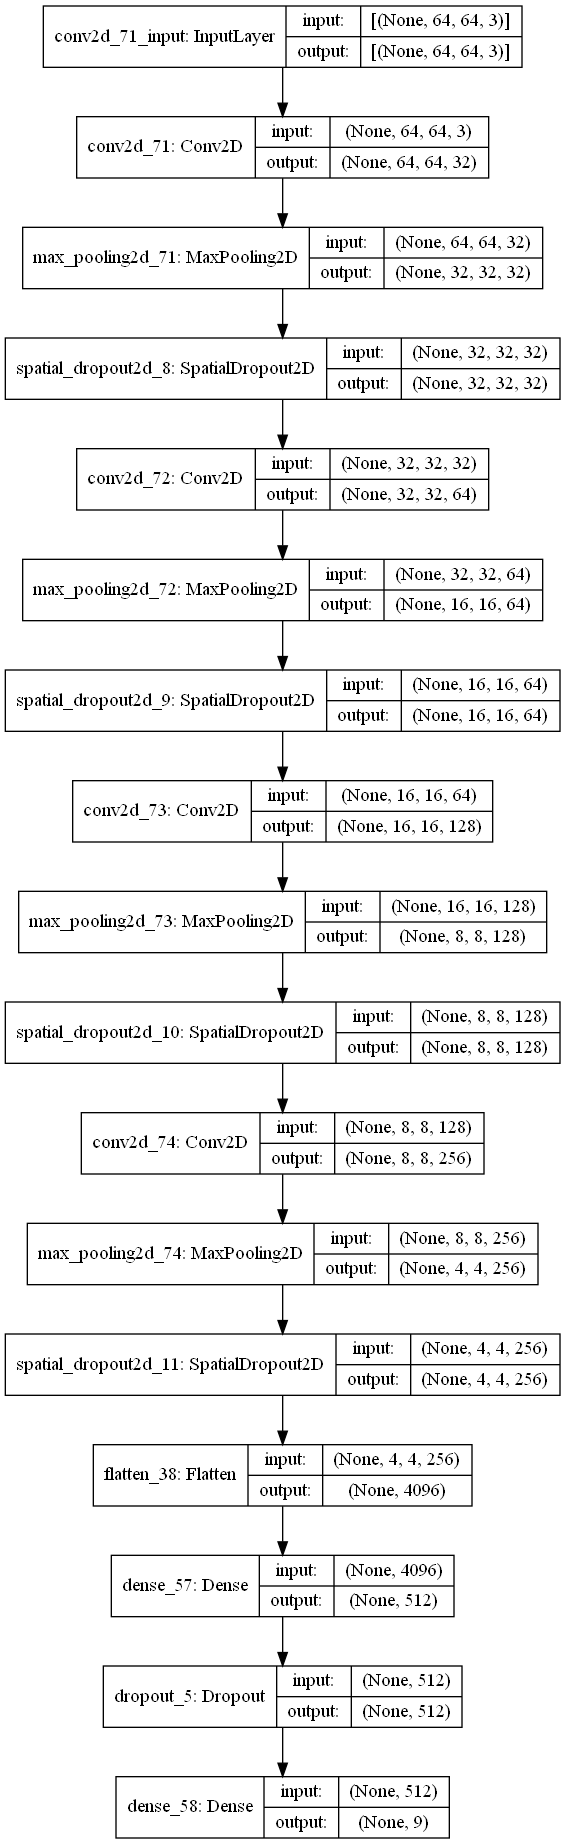

Epoch 1/70
600/600 [==============================] - 7s 11ms/step - loss: 2.1211 - accuracy: 0.1749 - val_loss: 1.7131 - val_accuracy: 0.3692
Epoch 2/70
600/600 [==============================] - 7s 11ms/step - loss: 1.7065 - accuracy: 0.3470 - val_loss: 1.6717 - val_accuracy: 0.3271
Epoch 3/70
600/600 [==============================] - 7s 11ms/step - loss: 1.5022 - accuracy: 0.4264 - val_loss: 1.2292 - val_accuracy: 0.5471
Epoch 4/70
600/600 [==============================] - 7s 11ms/step - loss: 1.3505 - accuracy: 0.4900 - val_loss: 1.1686 - val_accuracy: 0.5638
Epoch 5/70
600/600 [==============================] - 7s 11ms/step - loss: 1.2861 - accuracy: 0.5174 - val_loss: 1.1127 - val_accuracy: 0.5819
Epoch 6/70
600/600 [==============================] - 7s 11ms/step - loss: 1.1927 - accuracy: 0.5540 - val_loss: 1.0639 - val_accuracy: 0.6008
Epoch 7/70
600/600 [==============================] - 7s 11ms/step - loss: 1.1208 - accuracy: 0.5875 - val_loss: 1.0711 - val_accuracy: 0.5769

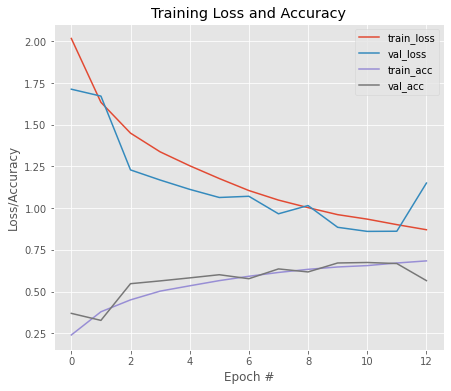

Model Performance Summary:
Best Validation Accuracy:  0.6741666793823242  at EPOCH: 10
Min validation loss: 0.8606634736061096  at EPOCH: 10


In [194]:
call_model(CONV4_sp_d512_drop_CNN,get_basic_callback())

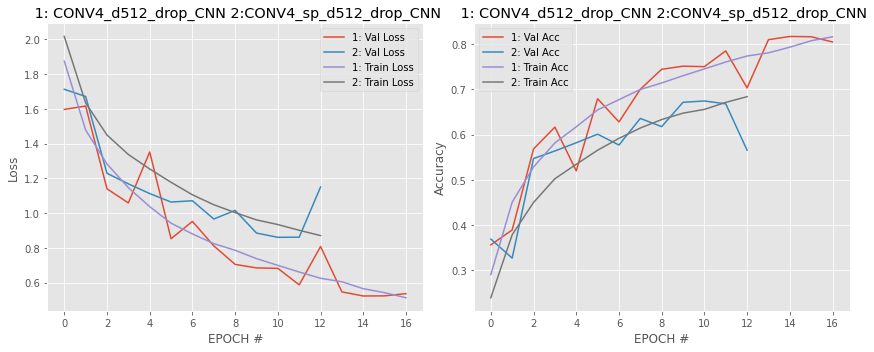

In [196]:
compare_model_performance_with_another("CONV4_d512_drop_CNN","CONV4_sp_d512_drop_CNN")

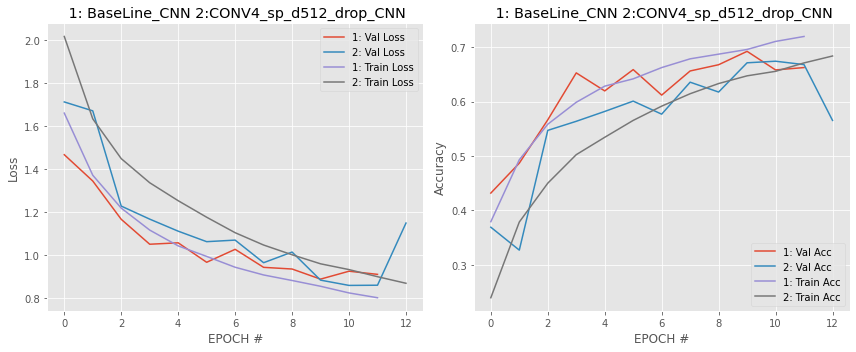

In [197]:
compare_model_performance_with_another("BaseLine_CNN","CONV4_sp_d512_drop_CNN")

# Model Performance Summary

BaseLine_CNN : 0.6922916769981384
Baseline_d512_CNN : 0.6822916865348816
CONV2_d512_CNN : 0.7083333134651184
CONV3_d512_CNN : 0.8266666531562805
CONV4_d512_CNN : 0.8197916746139526
CONV4_d512_drop_CNN : 0.8166666626930237
CONV4_sp_d512_drop_CNN : 0.6741666793823242


,Model,Val Acc
0,BaseLine_CNN,0.692292
1,Baseline_d512_CNN,0.682292
2,CONV2_d512_CNN,0.708333
3,CONV3_d512_CNN,0.826667
4,CONV4_d512_CNN,0.819792
5,CONV4_d512_drop_CNN,0.816667
6,CONV4_sp_d512_drop_CNN,0.674167


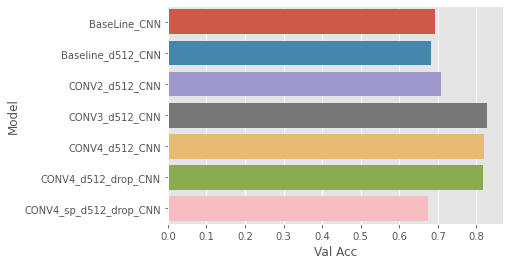

In [242]:
model_perfromance_summary()

# Image Data Augmentation
 ### 1. Augmentation Range
 ### 2. Horizontal & Vertical Flip

#### CONV4_d512_CNN

Model: "CONV4_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 8, 8, 256)      

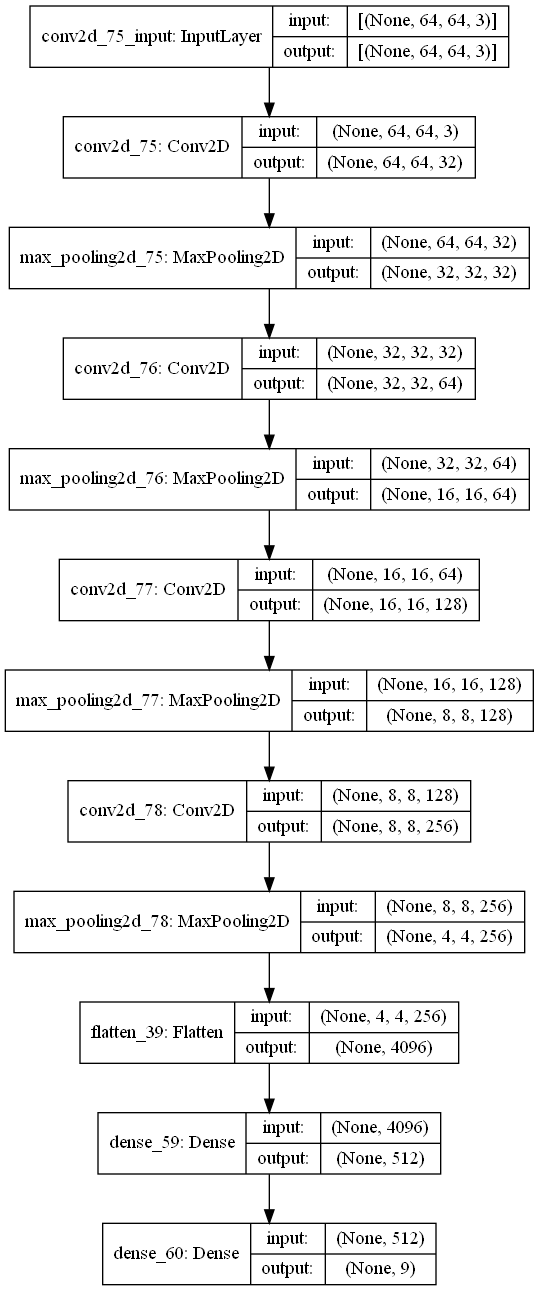

Epoch 1/70
600/600 [==============================] - 19s 31ms/step - loss: 2.0596 - accuracy: 0.2048 - val_loss: 1.5678 - val_accuracy: 0.3638
Epoch 2/70
600/600 [==============================] - 18s 30ms/step - loss: 1.5764 - accuracy: 0.4042 - val_loss: 1.3064 - val_accuracy: 0.5167
Epoch 3/70
600/600 [==============================] - 18s 31ms/step - loss: 1.3850 - accuracy: 0.4964 - val_loss: 1.2970 - val_accuracy: 0.5290
Epoch 4/70
600/600 [==============================] - 18s 30ms/step - loss: 1.2496 - accuracy: 0.5404 - val_loss: 1.4365 - val_accuracy: 0.4563
Epoch 5/70
600/600 [==============================] - 18s 30ms/step - loss: 1.1354 - accuracy: 0.5799 - val_loss: 1.0676 - val_accuracy: 0.6140
Epoch 6/70
600/600 [==============================] - 18s 30ms/step - loss: 1.0329 - accuracy: 0.6182 - val_loss: 0.9636 - val_accuracy: 0.6421
Epoch 7/70
600/600 [==============================] - 18s 30ms/step - loss: 0.9788 - accuracy: 0.6375 - val_loss: 0.8967 - val_accuracy:

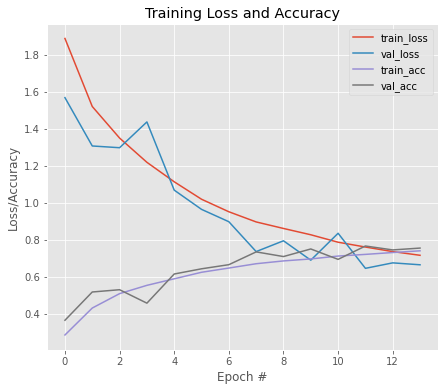

Model Performance Summary:
Best Validation Accuracy:  0.76541668176651  at EPOCH: 11
Min validation loss: 0.6446218490600586  at EPOCH: 11


In [199]:
 data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator(
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=30,    
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True
                        )
train_generator_full = data_generator_full.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        
call_model_with_augmentation(CONV4_d512_CNN,get_basic_callback(),\
                             generator_obj = train_generator_full)

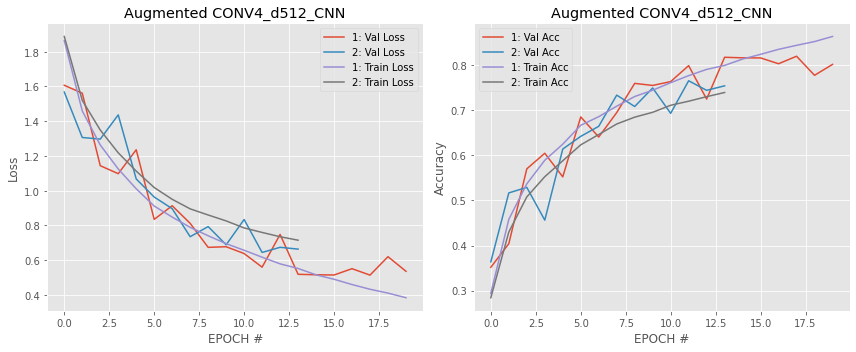

In [201]:
compare_model_performance_with_augmentation("CONV4_d512_CNN")

#### Horizontal and Vertical Flip

In [202]:
 data_generator_flip = tf.keras.preprocessing.image.ImageDataGenerator(      
                          horizontal_flip=True,
                          vertical_flip=True
                        )
 train_generator_flip = data_generator_flip.flow(g_trainX, g_trainY, \
                                                 batch_size=32)                        


Model: "CONV4_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 8, 8, 256)      

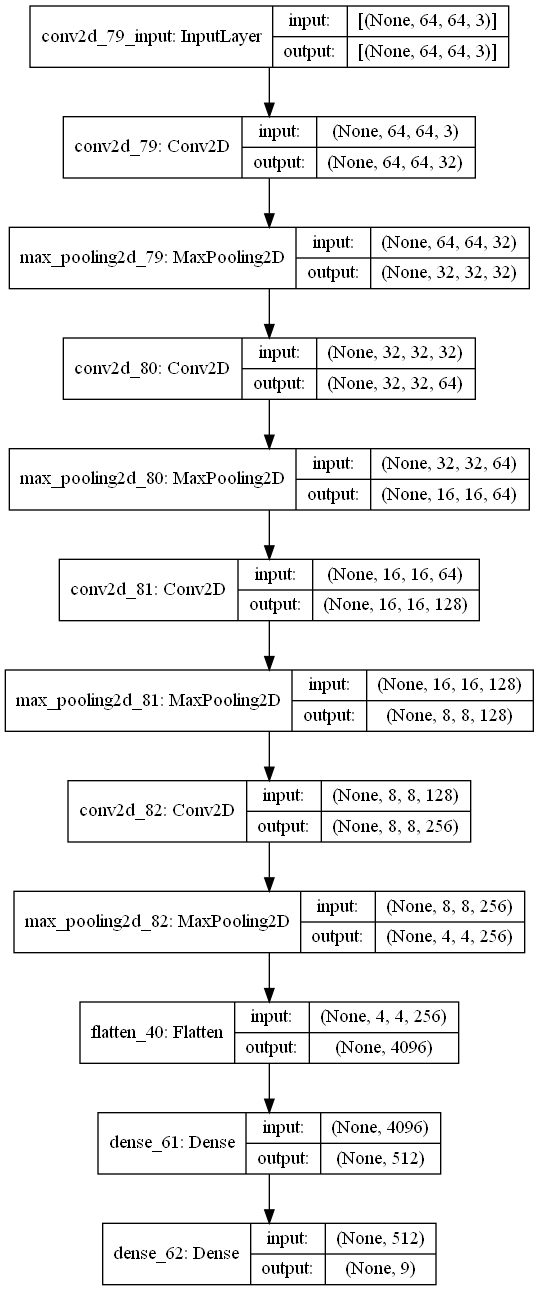

Epoch 1/70
600/600 [==============================] - 7s 11ms/step - loss: 2.0481 - accuracy: 0.2188 - val_loss: 1.6537 - val_accuracy: 0.3479
Epoch 2/70
600/600 [==============================] - 6s 10ms/step - loss: 1.5132 - accuracy: 0.4301 - val_loss: 1.2161 - val_accuracy: 0.5819
Epoch 3/70
600/600 [==============================] - 6s 10ms/step - loss: 1.3102 - accuracy: 0.5139 - val_loss: 1.4930 - val_accuracy: 0.4371
Epoch 4/70
600/600 [==============================] - 6s 10ms/step - loss: 1.1531 - accuracy: 0.5790 - val_loss: 1.0544 - val_accuracy: 0.6315
Epoch 5/70
600/600 [==============================] - 6s 10ms/step - loss: 1.0342 - accuracy: 0.6183 - val_loss: 0.9510 - val_accuracy: 0.6388
Epoch 6/70
600/600 [==============================] - 6s 10ms/step - loss: 0.9625 - accuracy: 0.6450 - val_loss: 0.8752 - val_accuracy: 0.6725
Epoch 7/70
600/600 [==============================] - 6s 10ms/step - loss: 0.8864 - accuracy: 0.6715 - val_loss: 0.8041 - val_accuracy: 0.7113

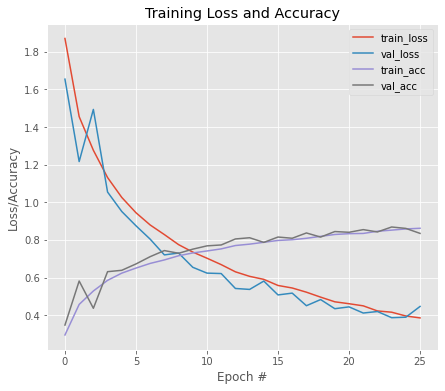

Model Performance Summary:
Best Validation Accuracy:  0.8687499761581421  at EPOCH: 23
Min validation loss: 0.38713324069976807  at EPOCH: 23


In [203]:
 call_model_with_augmentation(CONV4_d512_CNN,get_basic_callback(),\
                             generator_obj = train_generator_flip)

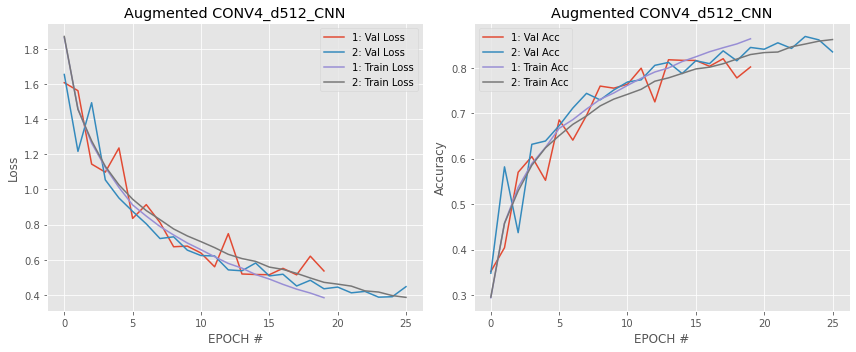

In [204]:
compare_model_performance_with_augmentation("CONV4_d512_CNN")

## CONV4_d512_drop_CNN

In [205]:
 data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator(
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=30,    
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True
                        )
train_generator_full = data_generator_full.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        


Model: "CONV4_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 8, 8, 256) 

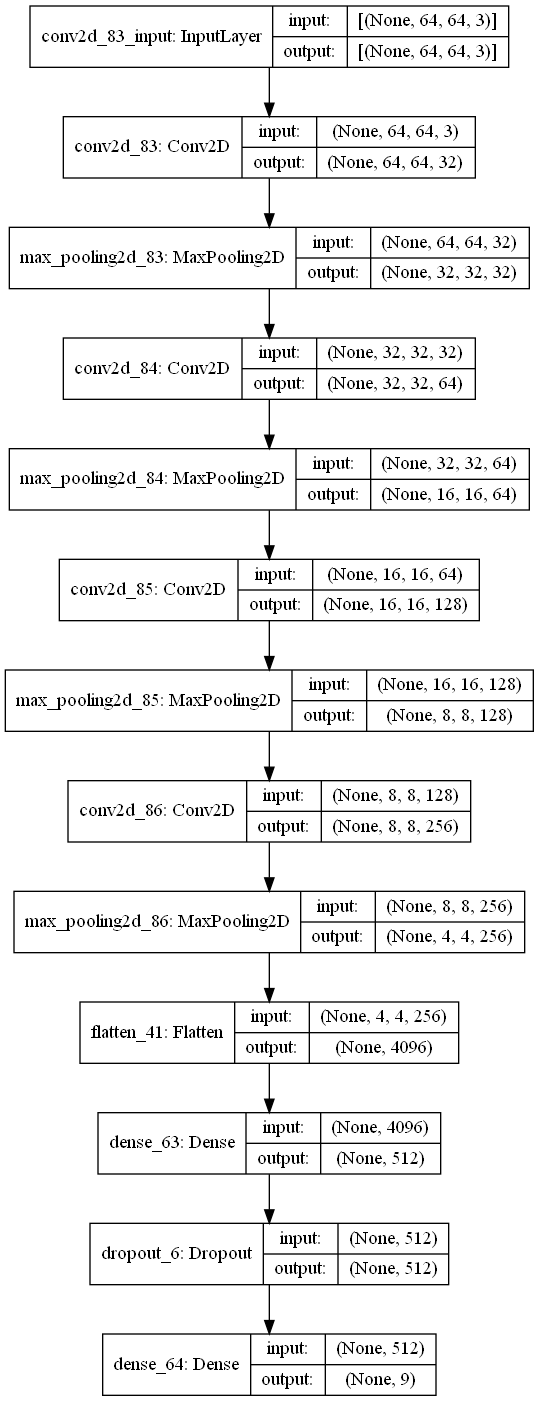

Epoch 1/70
600/600 [==============================] - 19s 31ms/step - loss: 2.0617 - accuracy: 0.2054 - val_loss: 1.5836 - val_accuracy: 0.3887
Epoch 2/70
600/600 [==============================] - 18s 31ms/step - loss: 1.5969 - accuracy: 0.3952 - val_loss: 1.4198 - val_accuracy: 0.4690
Epoch 3/70
600/600 [==============================] - 18s 31ms/step - loss: 1.4095 - accuracy: 0.4857 - val_loss: 1.2240 - val_accuracy: 0.5504
Epoch 4/70
600/600 [==============================] - 18s 31ms/step - loss: 1.2553 - accuracy: 0.5411 - val_loss: 1.0566 - val_accuracy: 0.6208
Epoch 5/70
600/600 [==============================] - 18s 30ms/step - loss: 1.1689 - accuracy: 0.5723 - val_loss: 0.9504 - val_accuracy: 0.6519
Epoch 6/70
600/600 [==============================] - 18s 31ms/step - loss: 1.0601 - accuracy: 0.6043 - val_loss: 0.9091 - val_accuracy: 0.6590
Epoch 7/70
600/600 [==============================] - 18s 30ms/step - loss: 0.9926 - accuracy: 0.6287 - val_loss: 1.0570 - val_accuracy:

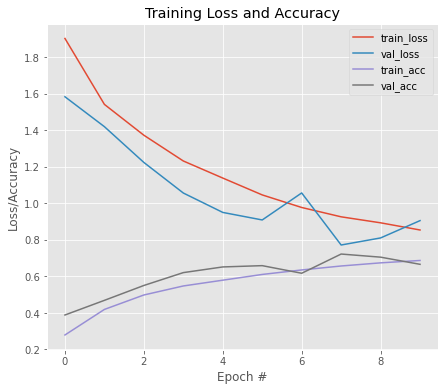

Model Performance Summary:
Best Validation Accuracy:  0.7225000262260437  at EPOCH: 7
Min validation loss: 0.7719713449478149  at EPOCH: 7


In [206]:
call_model_with_augmentation(CONV4_d512_drop_CNN,get_basic_callback(),\
                             generator_obj = train_generator_full)

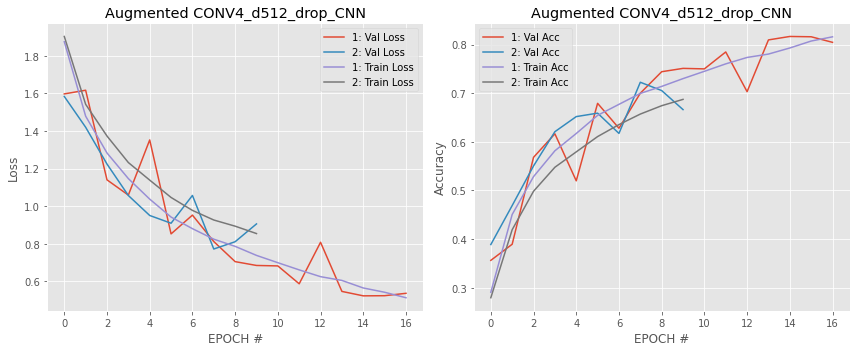

In [208]:
compare_model_performance_with_augmentation("CONV4_d512_drop_CNN")

## Horizontal and Vertical Flip

In [209]:
 data_generator_flip = tf.keras.preprocessing.image.ImageDataGenerator(      
                          horizontal_flip=True,
                          vertical_flip=True
                        )
 train_generator_flip = data_generator_flip.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        


Model: "CONV4_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 8, 8, 256) 

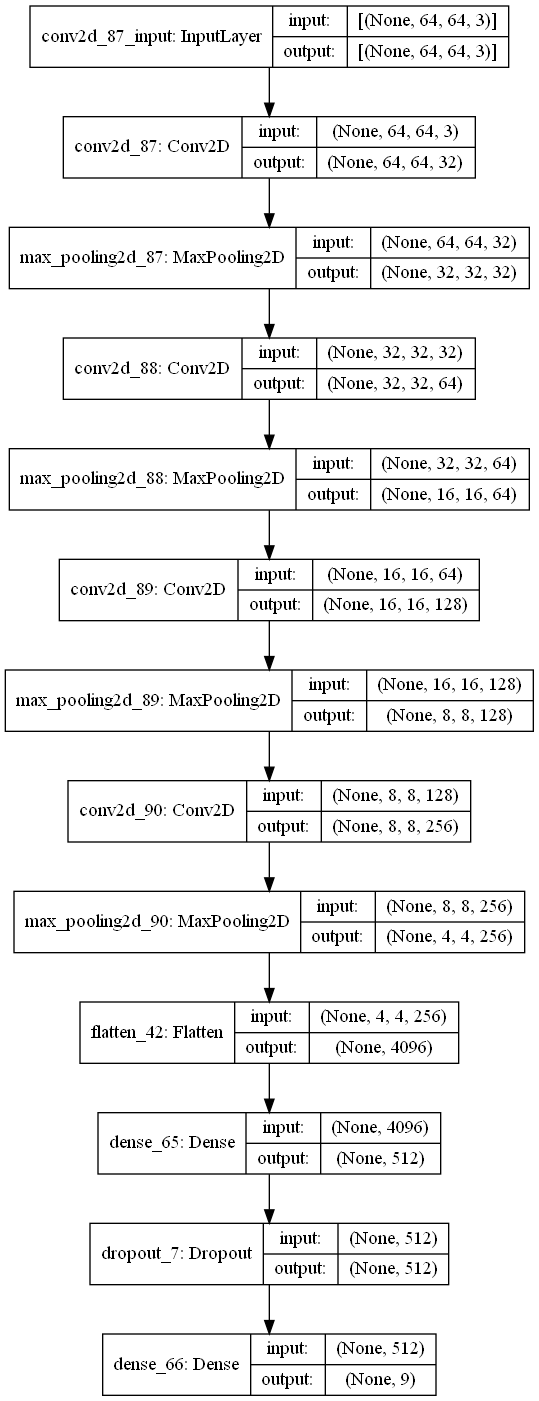

Epoch 1/70
600/600 [==============================] - 7s 11ms/step - loss: 2.0556 - accuracy: 0.2170 - val_loss: 1.5761 - val_accuracy: 0.4242
Epoch 2/70
600/600 [==============================] - 6s 10ms/step - loss: 1.5482 - accuracy: 0.4188 - val_loss: 1.2519 - val_accuracy: 0.5523
Epoch 3/70
600/600 [==============================] - 6s 10ms/step - loss: 1.3389 - accuracy: 0.5048 - val_loss: 1.1136 - val_accuracy: 0.5894
Epoch 4/70
600/600 [==============================] - 6s 10ms/step - loss: 1.1784 - accuracy: 0.5636 - val_loss: 1.1258 - val_accuracy: 0.5848
Epoch 5/70
600/600 [==============================] - 6s 10ms/step - loss: 1.0784 - accuracy: 0.6059 - val_loss: 0.8770 - val_accuracy: 0.6785
Epoch 6/70
600/600 [==============================] - 6s 10ms/step - loss: 0.9856 - accuracy: 0.6322 - val_loss: 0.8637 - val_accuracy: 0.6744
Epoch 7/70
600/600 [==============================] - 6s 10ms/step - loss: 0.9207 - accuracy: 0.6612 - val_loss: 0.8284 - val_accuracy: 0.6958

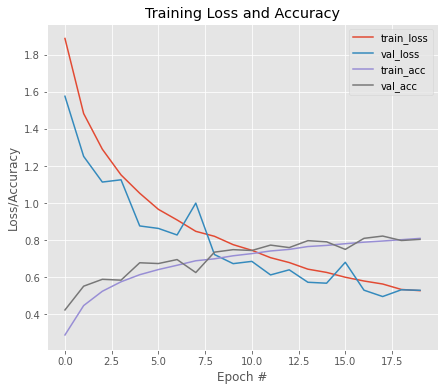

Model Performance Summary:
Best Validation Accuracy:  0.8224999904632568  at EPOCH: 17
Min validation loss: 0.4965333938598633  at EPOCH: 17


In [210]:
 call_model_with_augmentation(CONV4_d512_drop_CNN,get_basic_callback(),\
                             generator_obj = train_generator_flip)

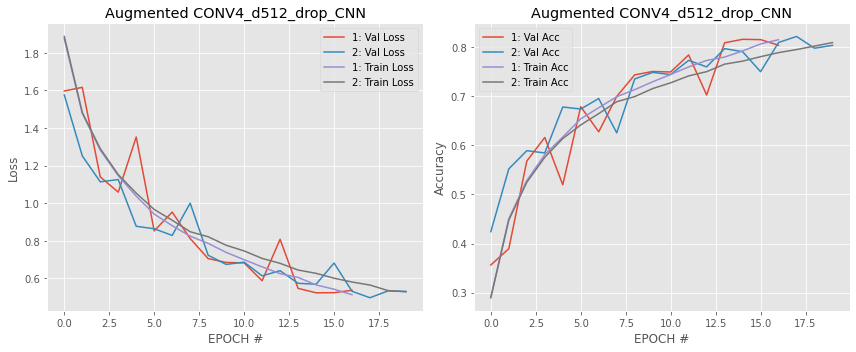

In [213]:
compare_model_performance_with_augmentation("CONV4_d512_drop_CNN")

# CONV4_sp_d512_drop_CNN

In [214]:
 data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator(
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=30,    
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True
                        )
train_generator_full = data_generator_full.flow(g_trainX, \
                                                  g_trainY, batch_size=32) 

Model: "CONV4_sp_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
spatial_dropout2d_12 (Spatia (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_13 (Spatia (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 16, 16, 

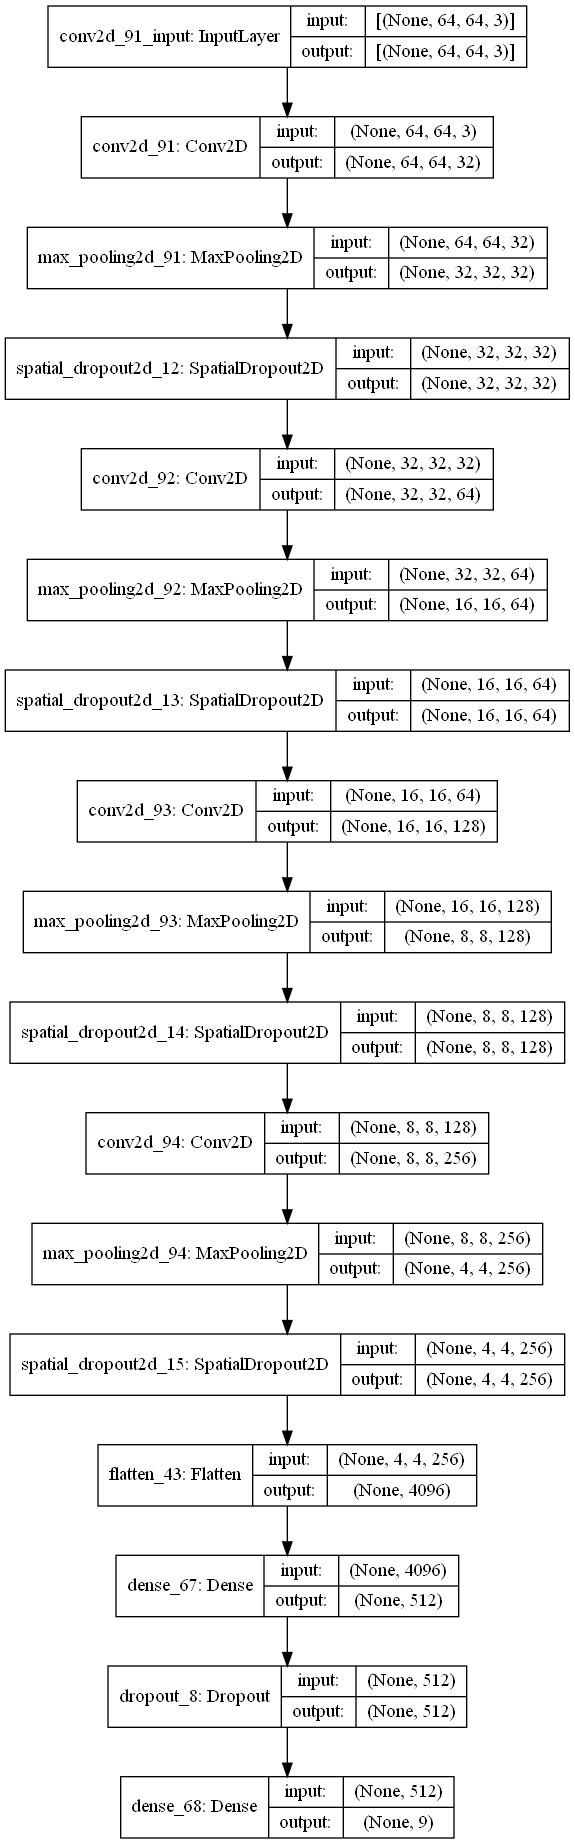

Epoch 1/70
600/600 [==============================] - 19s 31ms/step - loss: 2.1290 - accuracy: 0.1662 - val_loss: 1.7251 - val_accuracy: 0.3996
Epoch 2/70
600/600 [==============================] - 18s 31ms/step - loss: 1.7530 - accuracy: 0.3259 - val_loss: 1.4659 - val_accuracy: 0.4804
Epoch 3/70
600/600 [==============================] - 18s 30ms/step - loss: 1.5551 - accuracy: 0.4131 - val_loss: 1.3132 - val_accuracy: 0.5115
Epoch 4/70
600/600 [==============================] - 18s 31ms/step - loss: 1.4533 - accuracy: 0.4608 - val_loss: 1.2443 - val_accuracy: 0.5433
Epoch 5/70
600/600 [==============================] - 18s 31ms/step - loss: 1.3371 - accuracy: 0.5053 - val_loss: 1.1387 - val_accuracy: 0.5908
Epoch 6/70
600/600 [==============================] - 19s 31ms/step - loss: 1.2774 - accuracy: 0.5231 - val_loss: 1.0867 - val_accuracy: 0.6021
Epoch 7/70
600/600 [==============================] - 18s 30ms/step - loss: 1.2118 - accuracy: 0.5495 - val_loss: 1.0916 - val_accuracy:

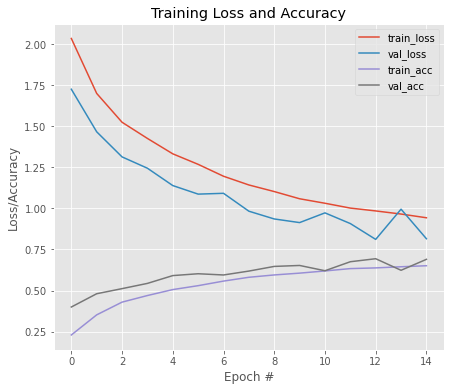

Model Performance Summary:
Best Validation Accuracy:  0.6935416460037231  at EPOCH: 12
Min validation loss: 0.8111633062362671  at EPOCH: 12


In [215]:
call_model_with_augmentation(CONV4_sp_d512_drop_CNN,get_basic_callback(),\
                             generator_obj = train_generator_full)

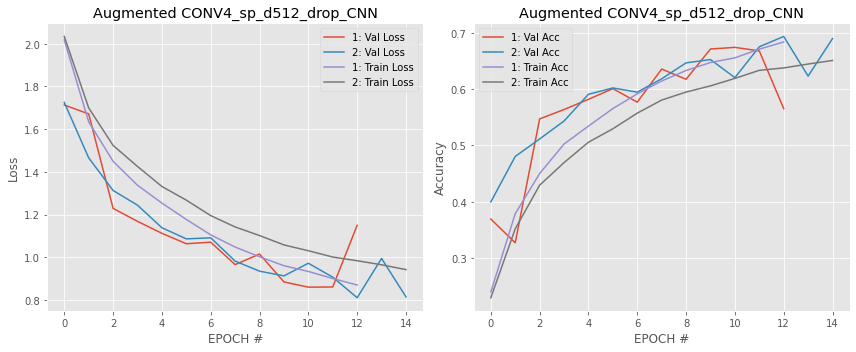

In [216]:
compare_model_performance_with_augmentation("CONV4_sp_d512_drop_CNN")

In [217]:
 data_generator_flip = tf.keras.preprocessing.image.ImageDataGenerator(      
                          horizontal_flip=True,
                          vertical_flip=True
                        )
 train_generator_flip = data_generator_flip.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        


Model: "CONV4_sp_d512_drop_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
spatial_dropout2d_16 (Spatia (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_17 (Spatia (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 16, 16, 

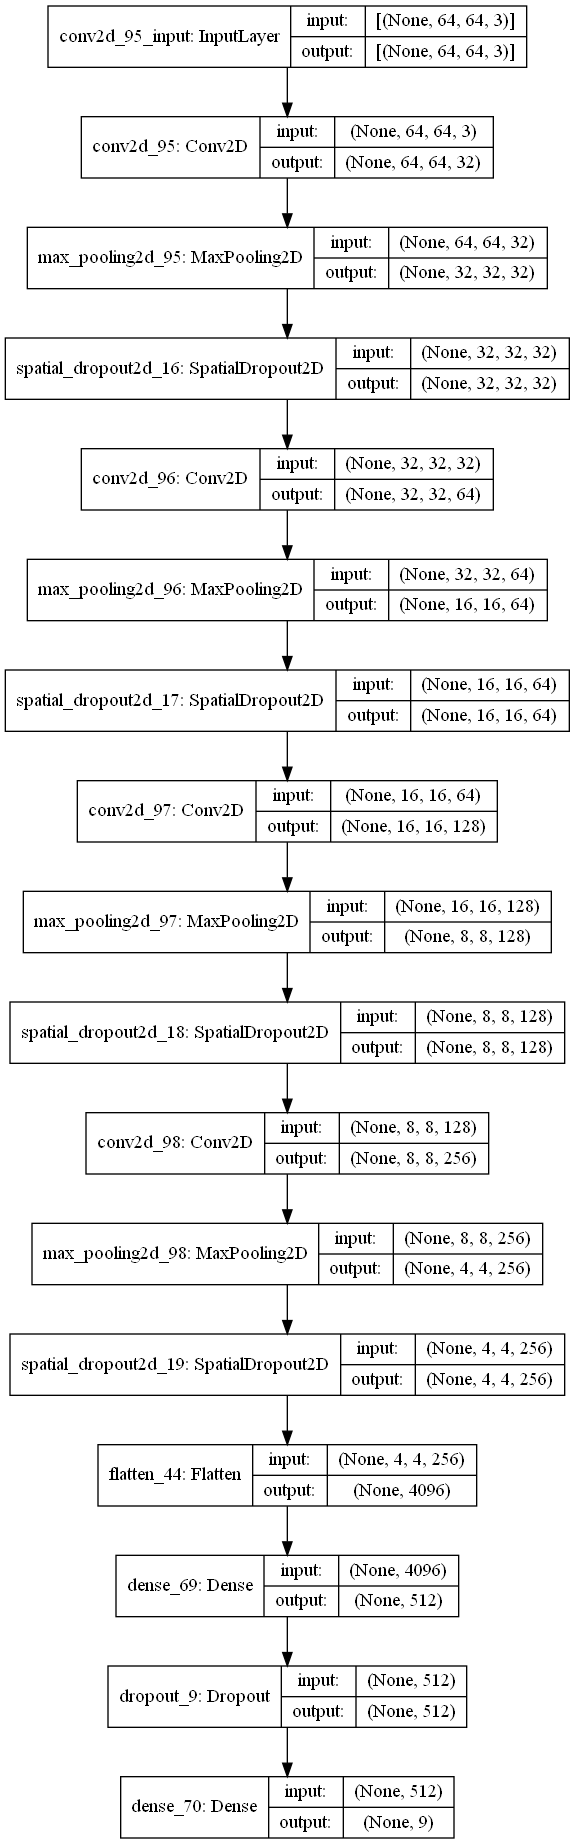

Epoch 1/70
600/600 [==============================] - 9s 13ms/step - loss: 2.1254 - accuracy: 0.1752 - val_loss: 1.7615 - val_accuracy: 0.3487
Epoch 2/70
600/600 [==============================] - 8s 14ms/step - loss: 1.7228 - accuracy: 0.3408 - val_loss: 1.3933 - val_accuracy: 0.4929
Epoch 3/70
600/600 [==============================] - 9s 15ms/step - loss: 1.4893 - accuracy: 0.4365 - val_loss: 1.3360 - val_accuracy: 0.4915
Epoch 4/70
600/600 [==============================] - 9s 16ms/step - loss: 1.3950 - accuracy: 0.4733 - val_loss: 1.1760 - val_accuracy: 0.5792
Epoch 5/70
600/600 [==============================] - 10s 16ms/step - loss: 1.2894 - accuracy: 0.5269 - val_loss: 1.0802 - val_accuracy: 0.6131
Epoch 6/70
600/600 [==============================] - 9s 16ms/step - loss: 1.2076 - accuracy: 0.5533 - val_loss: 1.0835 - val_accuracy: 0.5877
Epoch 7/70
600/600 [==============================] - 9s 16ms/step - loss: 1.1391 - accuracy: 0.5806 - val_loss: 0.9973 - val_accuracy: 0.617

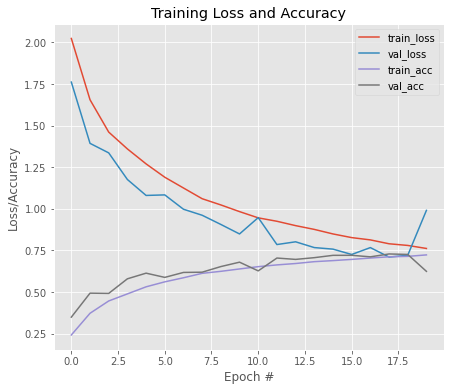

Model Performance Summary:
Best Validation Accuracy:  0.7285416722297668  at EPOCH: 17
Min validation loss: 0.7098352313041687  at EPOCH: 17


In [218]:
 call_model_with_augmentation(CONV4_sp_d512_drop_CNN,get_basic_callback(),\
                             generator_obj = train_generator_flip)

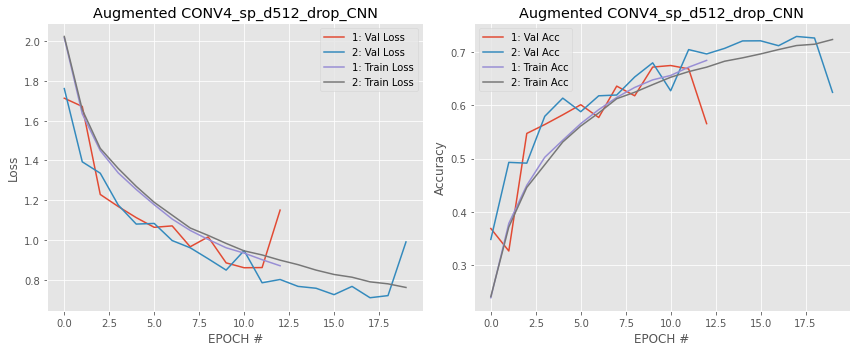

In [219]:
compare_model_performance_with_augmentation("CONV4_sp_d512_drop_CNN")

# Model Perfromance Summary With Augmentation

CONV4_d512_CNN : 0.8687499761581421
CONV4_d512_drop_CNN : 0.8224999904632568
CONV4_sp_d512_drop_CNN : 0.7285416722297668


,Model,Val Acc
0,CONV4_d512_CNN,0.868750
1,CONV4_d512_drop_CNN,0.822500
2,CONV4_sp_d512_drop_CNN,0.728542


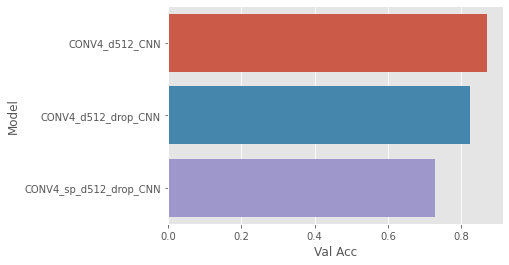

In [243]:
model_perfromance_summary_with_augmentation()

#### Model "CONV4_d512_CNN" has performed best amongest choosen model with horizontal & vertical flip

# Varying Learning Rate:

Model: "BaseLine_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_73 (Dense)             (None, 9)                 294921    
Total params: 295,817
Trainable params: 295,817
Non-trainable params: 0
_________________________________________________________________
None


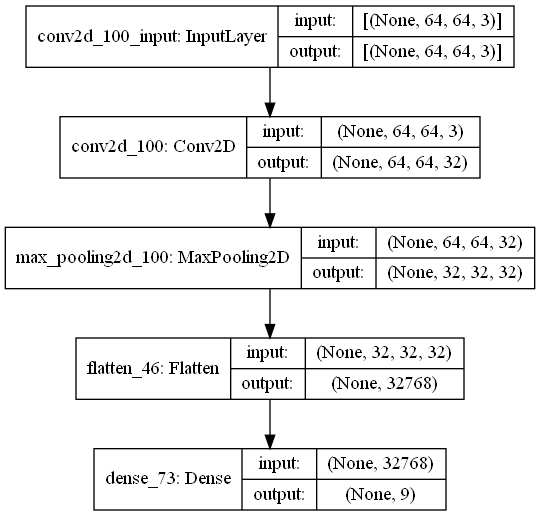

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.8432 - accuracy: 0.3105 - val_loss: 1.4679 - val_accuracy: 0.4319
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.4263 - accuracy: 0.4712 - val_loss: 1.3457 - val_accuracy: 0.4869
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.2766 - accuracy: 0.5362 - val_loss: 1.1679 - val_accuracy: 0.5663
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.1264 - accuracy: 0.5907 - val_loss: 1.0519 - val_accuracy: 0.6527
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

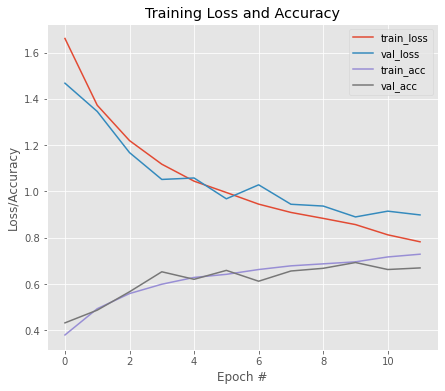

Model Performance Summary:
Best Validation Accuracy:  0.6927083134651184  at EPOCH: 9
Min validation loss: 0.8898003101348877  at EPOCH: 9


In [223]:
call_model(BaseLine_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

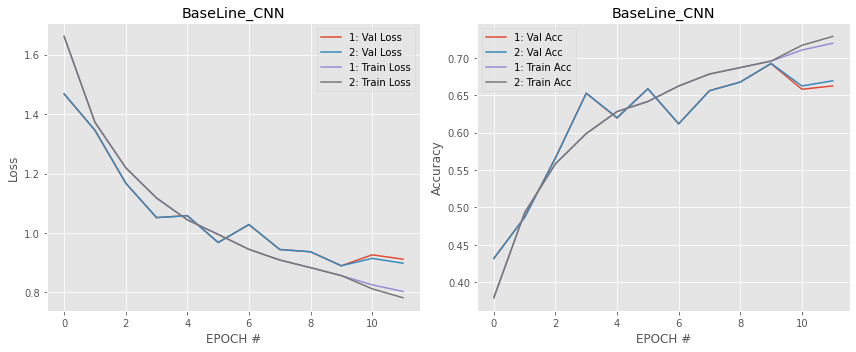

In [224]:
compare_model_performance_with_lrs("BaseLine_CNN")

Model: "Baseline_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dense_72 (Dense)             (None, 9)                 4617      
Total params: 16,783,241
Trainable params: 16,783,241
Non-trainable params: 0
_________________________________________________________________
None


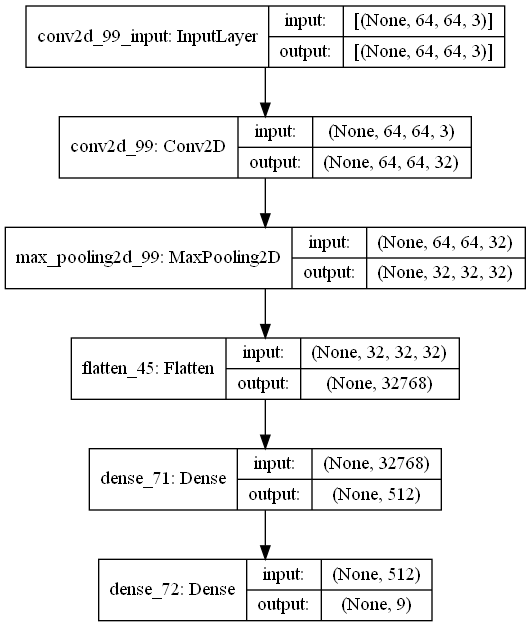

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 9ms/step - loss: 1.8404 - accuracy: 0.3096 - val_loss: 1.5175 - val_accuracy: 0.4238
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 8ms/step - loss: 1.4330 - accuracy: 0.4693 - val_loss: 1.3913 - val_accuracy: 0.4762
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 8ms/step - loss: 1.3048 - accuracy: 0.5214 - val_loss: 1.1342 - val_accuracy: 0.5821
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 9ms/step - loss: 1.1378 - accuracy: 0.5865 - val_loss: 1.0280 - val_accuracy: 0.6506
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

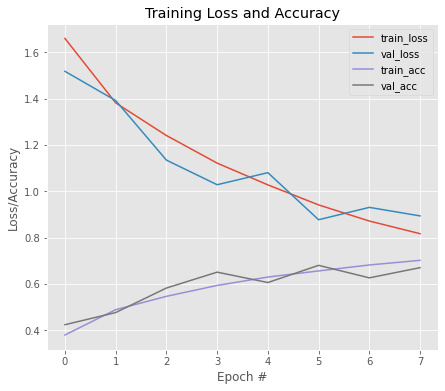

Model Performance Summary:
Best Validation Accuracy:  0.6800000071525574  at EPOCH: 5
Min validation loss: 0.8769187331199646  at EPOCH: 5


In [221]:
call_model(Baseline_d512_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

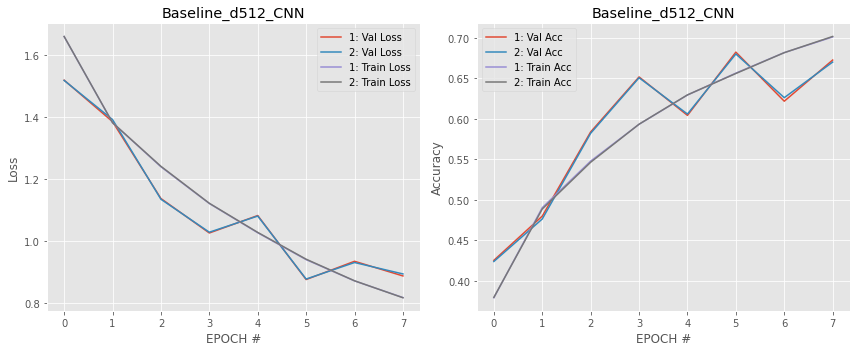

In [222]:
compare_model_performance_with_lrs("Baseline_d512_CNN")

Model: "CONV2_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_74 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dense_75 (Dense)             (None, 9)              

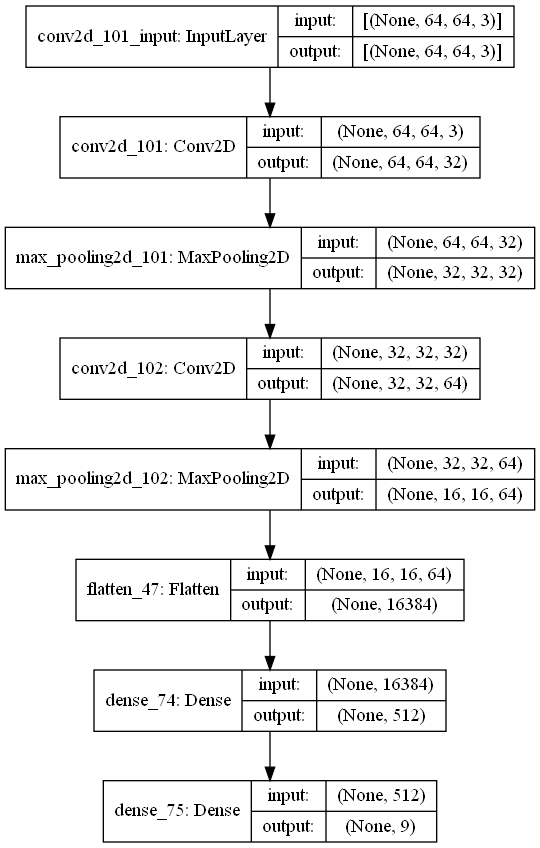

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 9ms/step - loss: 1.9013 - accuracy: 0.2820 - val_loss: 1.5380 - val_accuracy: 0.3925
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 9ms/step - loss: 1.4199 - accuracy: 0.4724 - val_loss: 1.4314 - val_accuracy: 0.4560
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 9ms/step - loss: 1.2582 - accuracy: 0.5404 - val_loss: 1.0579 - val_accuracy: 0.6110
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 9ms/step - loss: 1.0707 - accuracy: 0.6098 - val_loss: 0.9454 - val_accuracy: 0.6681
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

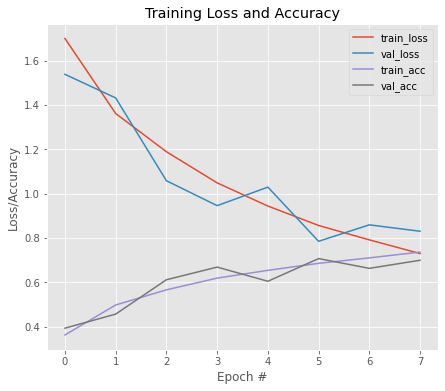

Model Performance Summary:
Best Validation Accuracy:  0.706458330154419  at EPOCH: 5
Min validation loss: 0.7845672369003296  at EPOCH: 5


In [225]:
call_model(CONV2_d512_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

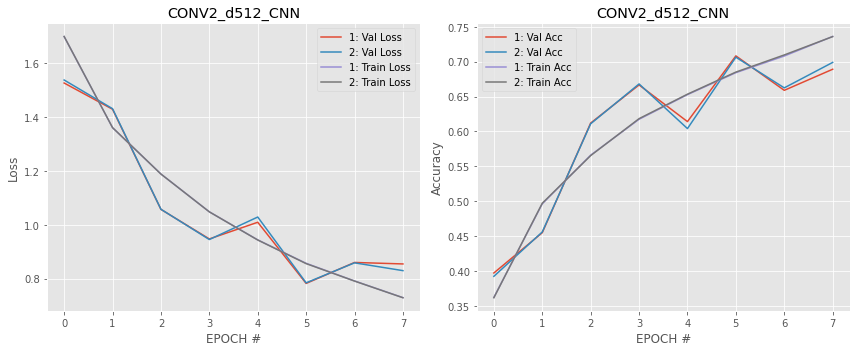

In [226]:
compare_model_performance_with_lrs("CONV2_d512_CNN")

Model: "CONV3_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 8192)           

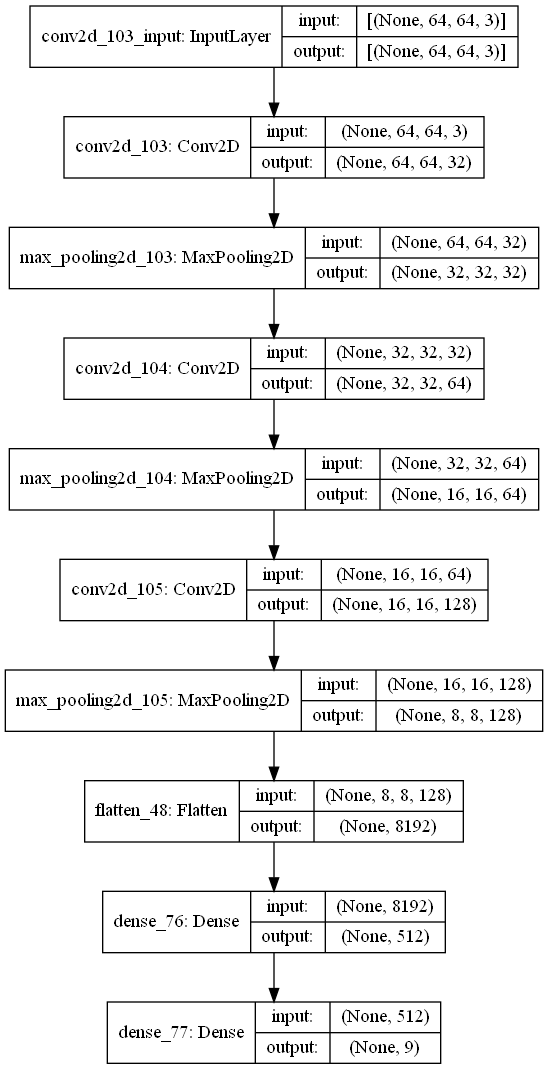

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.9825 - accuracy: 0.2617 - val_loss: 1.4789 - val_accuracy: 0.4406
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 9ms/step - loss: 1.4406 - accuracy: 0.4693 - val_loss: 1.4285 - val_accuracy: 0.4548
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 9ms/step - loss: 1.2733 - accuracy: 0.5331 - val_loss: 1.1016 - val_accuracy: 0.5821
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 9ms/step - loss: 1.0980 - accuracy: 0.5996 - val_loss: 0.9791 - val_accuracy: 0.6513
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.


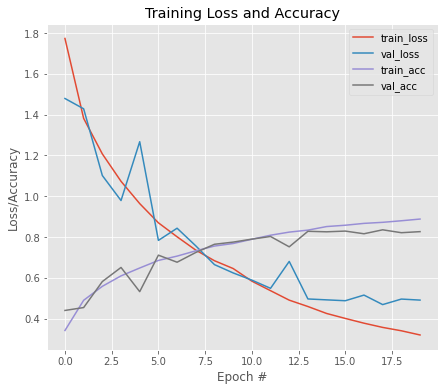

Model Performance Summary:
Best Validation Accuracy:  0.8356249928474426  at EPOCH: 17
Min validation loss: 0.469301700592041  at EPOCH: 17


In [227]:
call_model(CONV3_d512_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

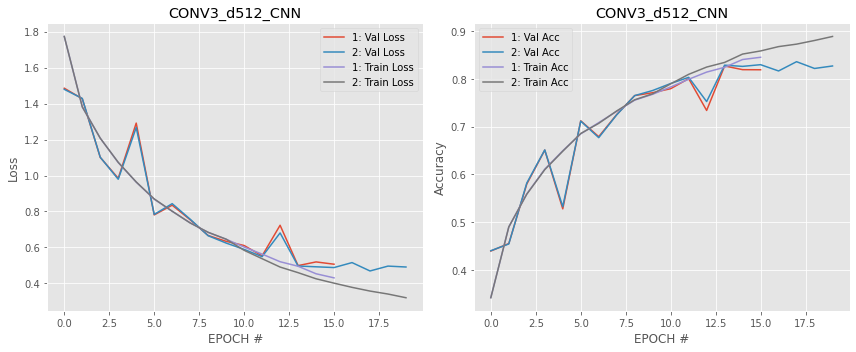

In [228]:
compare_model_performance_with_lrs("CONV3_d512_CNN")

Model: "CONV4_d512_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 8, 8, 256)      

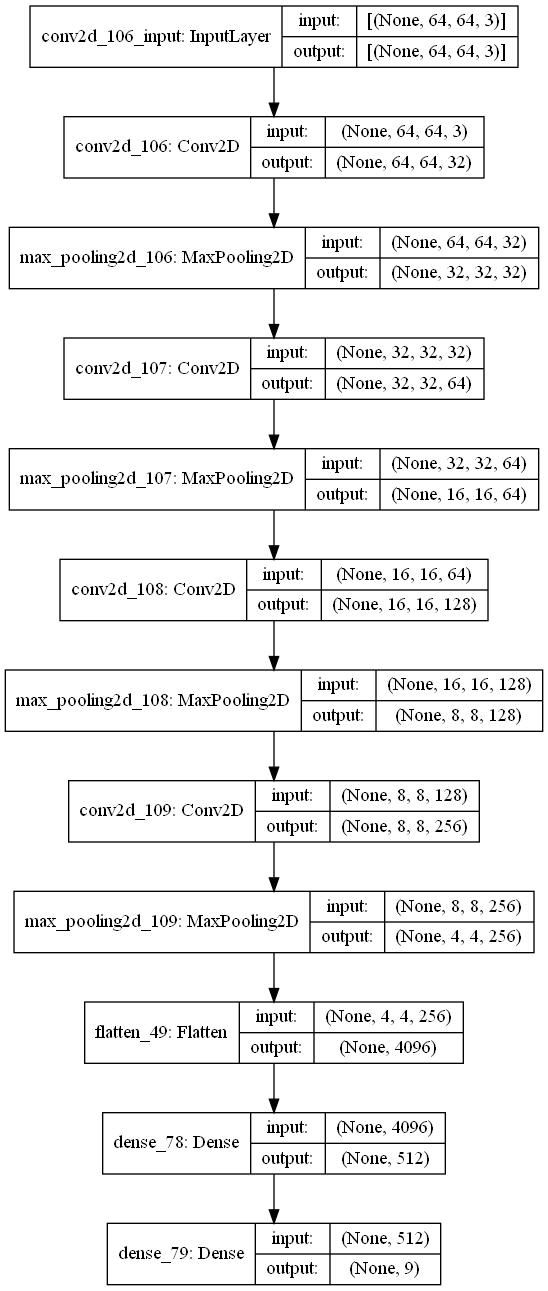

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 7s 11ms/step - loss: 2.0473 - accuracy: 0.2112 - val_loss: 1.6120 - val_accuracy: 0.3477
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.5307 - accuracy: 0.4249 - val_loss: 1.5661 - val_accuracy: 0.4050
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.3282 - accuracy: 0.5131 - val_loss: 1.1395 - val_accuracy: 0.5692
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.1539 - accuracy: 0.5774 - val_loss: 1.0812 - val_accuracy: 0.6152
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00999999977648258

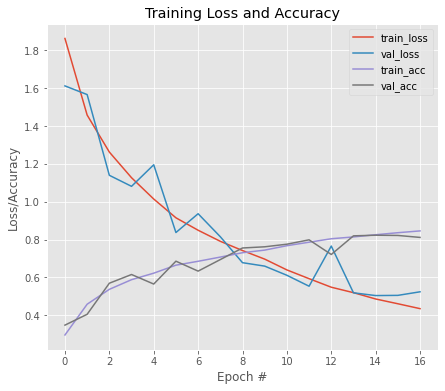

Model Performance Summary:
Best Validation Accuracy:  0.8229166865348816  at EPOCH: 14
Min validation loss: 0.5039692521095276  at EPOCH: 14


In [229]:
call_model(CONV4_d512_CNN,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

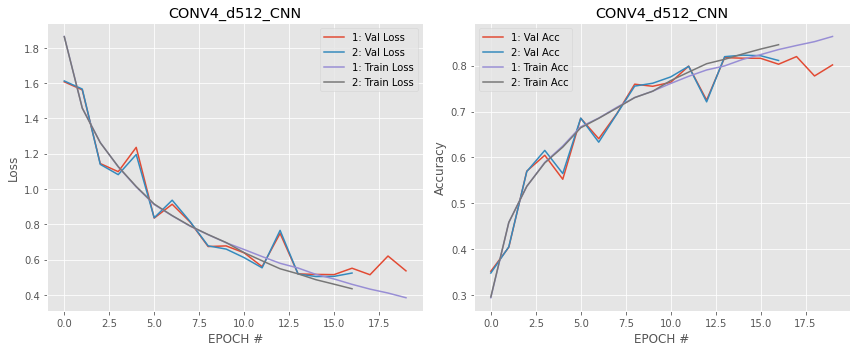

In [231]:
compare_model_performance_with_lrs("CONV4_d512_CNN")

In [248]:
!nvidia-smi

Tue Apr 27 21:01:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000 wi... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8     1W /  N/A |   3019MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [247]:
gc.collect()

40958